-----
# 02 - Unibiomarker Analysis

In [1]:
from pathlib import Path
import seaborn as sns
import pandas as pd

from utils import format_dataframe, add_ratio_columns
from unibiomarker import Unibiomarker
import constants

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Default Plot Style : 
sns.set(style="whitegrid")


## 1. Data Loading & Preparation

In [2]:
# Set path to Data Directory : 
DIR_DATA = Path.cwd() / "data"

# Check existence to training/test files : 
print(fr"Data Directory    : {str(DIR_DATA)}")
print(fr"Train Data exists : {(DIR_DATA / 'cercare_training_data.xlsx').exists()}")
print(fr"Test Data exists  : {(DIR_DATA / 'cercare_test_data.xlsx').exists()}")


Data Directory    : C:\Users\maichi\work\my_projects\CercareStatAnalysis\data
Train Data exists : True
Test Data exists  : True


In [3]:
# Load Cercare Training / Test Excel spreadsheets :
df_data = pd.read_excel(DIR_DATA / "cercare_training_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)
df_test = pd.read_excel(DIR_DATA / "cercare_test_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)

# Format dataframes : 
df_data = format_dataframe(df=df_data)
df_test = format_dataframe(df=df_test)

# Add the ratio columns : 
add_ratio_columns(df_data)
add_ratio_columns(df_test)

print("Data Loaded and formatted Successfully ! ")


Data Loaded and formatted Successfully ! 


##  2. 🔧  Configuration 

In [4]:
BIOMARKER = "DELAY"  # Choose from :  ADC, CBV_corr, CBV_noncorr, DELAY, CTH, CTH MAX, OEF, rLEAKAGE, rCMRO2, COV

In [5]:
# Unibiomarker object Initialization : 
ub = Unibiomarker(name=BIOMARKER, data = df_data, test_data=df_test)
print(ub)


Biomarker object
- Parameters: DELAY_lésion, DELAY_control, DELAY_ratio
- Training samples: 182
- Test samples: 23



## 3. Descriptive Analysis

### 3.1 Check for missing values

Fully usable rows in train: 177/182 (97.3%)
Fully usable rows in test:  23/23 (100.0%)


,Train Missing %,Test Missing %
DELAY_lésion,0.5,0.0
DELAY_control,2.7,0.0
DELAY_ratio,2.7,0.0


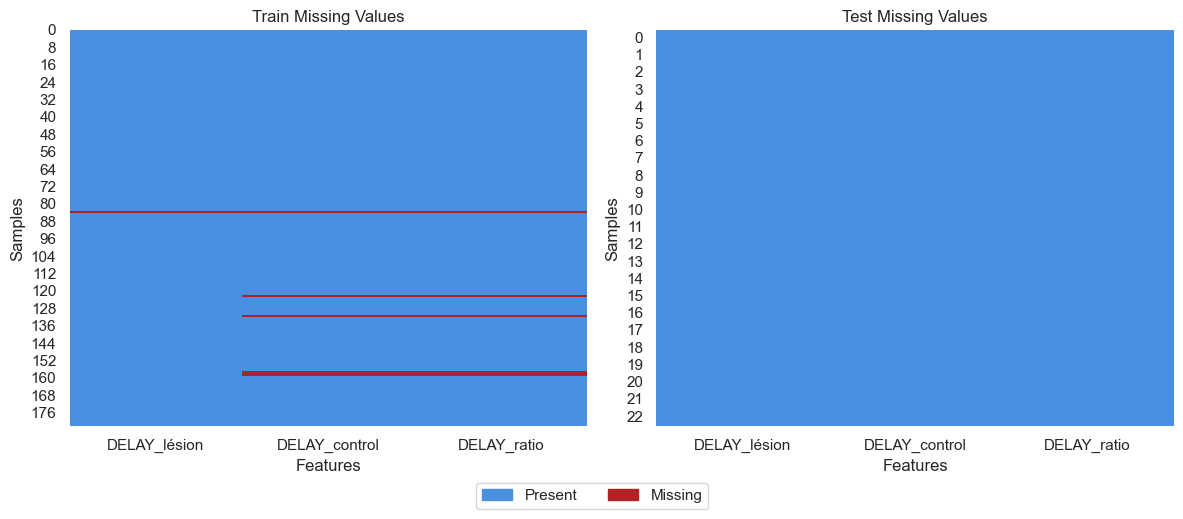

In [6]:
ub.check_missing_data()


### 3.2 Describe & Visualize key features

In [7]:
ub.describe_features(features=[ub.path, ub.control])


Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
DELAY_lésion,181.0,1.403923,1.760170,0.02,0.25,0.55,1.98,8.66
DELAY_control,177.0,1.629887,2.111195,0.01,0.40,0.87,2.08,15.58



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,DELAY_lésion,0,110.0,0.587182,0.877804,0.02,0.170,0.325,0.5825,5.77
2,DELAY_lésion,1,71.0,2.669296,2.023528,0.13,0.810,2.450,3.5450,8.66
1,DELAY_control,0,106.0,2.295472,2.469866,0.20,0.690,1.700,2.7600,15.58
3,DELAY_control,1,71.0,0.636197,0.619528,0.01,0.205,0.400,0.8700,2.60


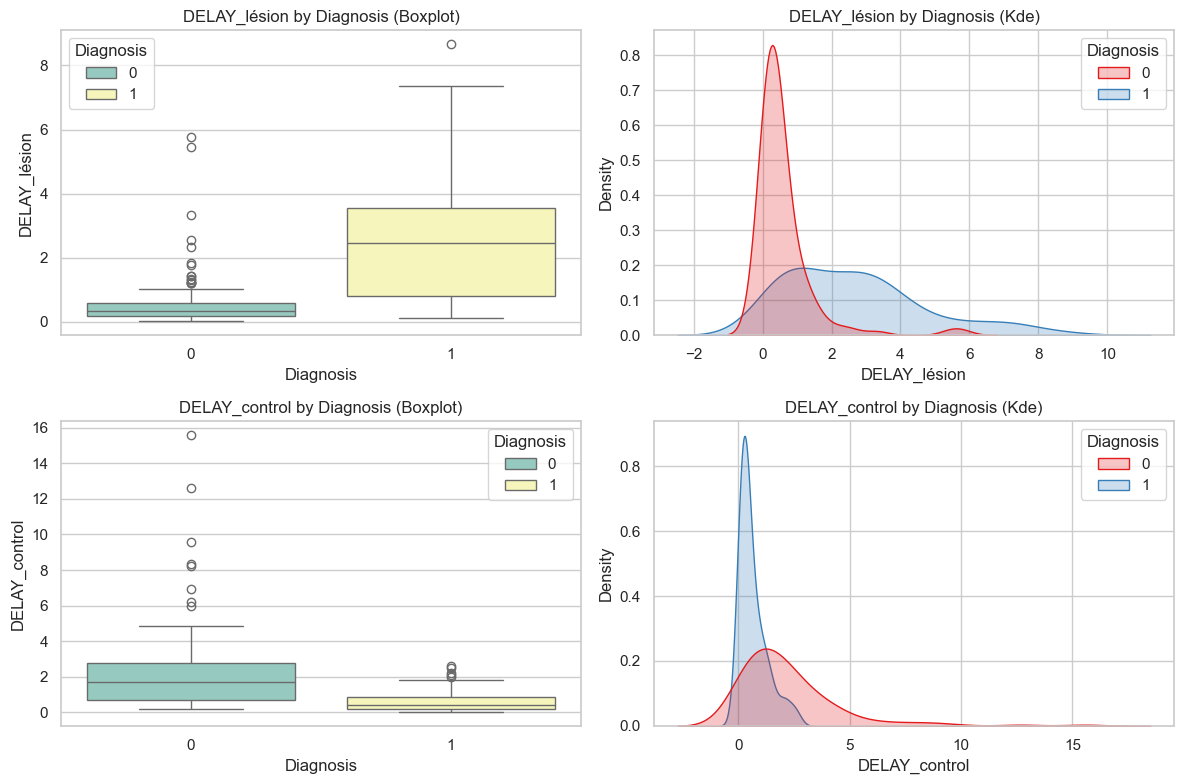

In [8]:
ub.plot_feature_distributions(features=[ub.path, ub.control], plots=["boxplot", "kde"])


### 3.3 Ratio Analysis

The goal of this section is to check correlation between the path variable and the control variable

The ratio is defined as:  
**`Ratio = Path / Control`**

To assess whether this ratio provides *new, meaningful information*, we first examine the correlation between `Path` and `Control` values:

---

#### 🔍 What we check

1. **Pearson correlation** (linear relationship)  
   Measures the strength of a **linear** association between `Path` and `Control`.

   $$
   r = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}
   $$

2. **Spearman correlation** (monotonic relationship)  
   Applies the Pearson formula to the **ranked values** rather than raw values.

   $$
   \rho = \frac{\text{Cov}(\text{Rank}(X), \text{Rank}(Y))}{\sigma_{\text{Rank}(X)} \cdot \sigma_{\text{Rank}(Y)}}
   $$

   This makes Spearman suitable for detecting **monotonic relationships** that are not necessarily linear.

3. **Statistical significance** (p-values)  
   For both Pearson and Spearman, a **p-value** tests the null hypothesis that the correlation is zero (i.e., no association exists):

   - A **low p-value** (typically < 0.05) indicates that the correlation is **statistically significant**  
   - A **high p-value** means there is **insufficient evidence** to conclude that a statistically significant correlation exists
     

In [9]:
ub.describe_features(features=[ub.ratio])

Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
DELAY_ratio,177.0,2.642387,4.900261,0.023529,0.209091,0.380682,3.350515,47.0



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,DELAY_ratio,0,106.0,0.257721,0.180935,0.023529,0.146942,0.242463,0.324831,1.428571
1,DELAY_ratio,1,71.0,6.202592,6.233619,0.270833,3.148864,4.162791,6.581250,47.000000


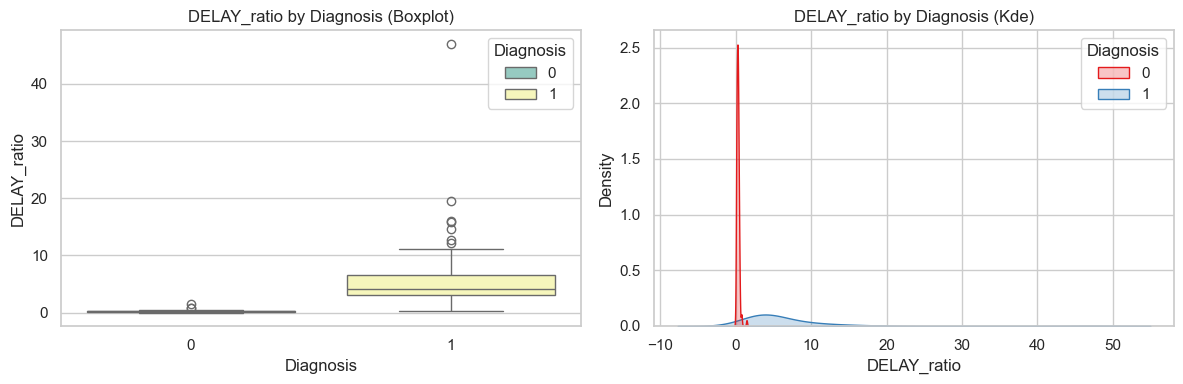

In [10]:
ub.plot_feature_distributions(features=[ub.ratio], plots=["boxplot", "kde"])

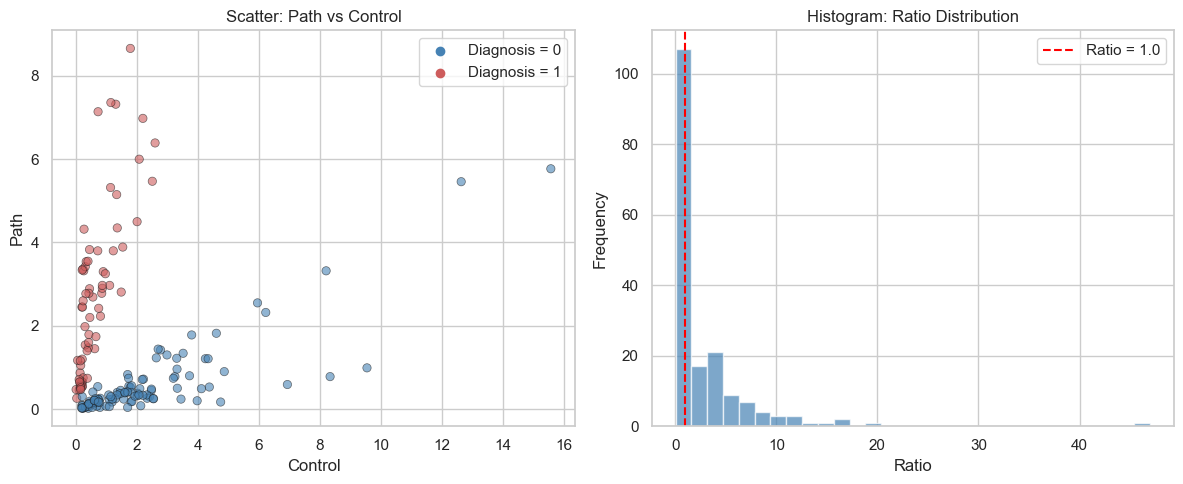

In [11]:
ub.plot_diagnostic_scatter_and_ratio()

In [12]:
ub.evaluate_path_control_correlation()

🔍 Analyzing Biomarker: DELAY
------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 1: Correlation Analysis between Path and Control 
------------------------------------------------------------------------------------------------------------------------------------------------------
- Pearson  correlation: r = 0.177, p = 0.0183
- Spearman correlation: r = 0.125, p = 0.0969

------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 2: Interpretation Guidance 
------------------------------------------------------------------------------------------------------------------------------------------------------
Red Flag ! Pearson correlation is statistically significant (p < 0.05), but Spearman is not !


## 4.  Discriminative Power of the Biomarker


In this section, we assess whether features like `path` and `ratio` can **discriminate between diagnostic groups**, such as Tumor Recurrence and Radiation Necrosis.

---

#### Step 1 – Normality Check

We start with **Q–Q plots** to visually evaluate whether the distribution of the feature within each group appears **approximately normal**. This helps decide whether we can meaningfully apply a parametric test that models the **data distribution**.

---
#### Step 2 – Choosing the Right Statistical Test

- If the feature appears **normally distributed** in each group, we apply a **Welch’s t-test**.
  - This test assumes the data follows a normal distribution and compares the **means** between groups.
  - Using a parametric test like this is valuable because it lets us **model the data with a known distribution**

- If the feature **does not appear normally distributed**, we instead use the **Mann–Whitney U test**.
  - This is a **non-parametric** test that compares whether values in one group tend to be higher or lower than in the other.
  - It doesn’t assume any specific distribution and works on **ranked data** rather than actual values.
  - But it doesn’t let us **model or describe the underlying distribution** of the data 

---

#### Step 3 – Interpreting the Results

If either test reports a **statistically significant difference** (typically p < 0.05), it suggests that the feature behaves differently between groups — a necessary condition for it to be useful as a biomarker

### 4.1. Distribution Differences: Path Feature

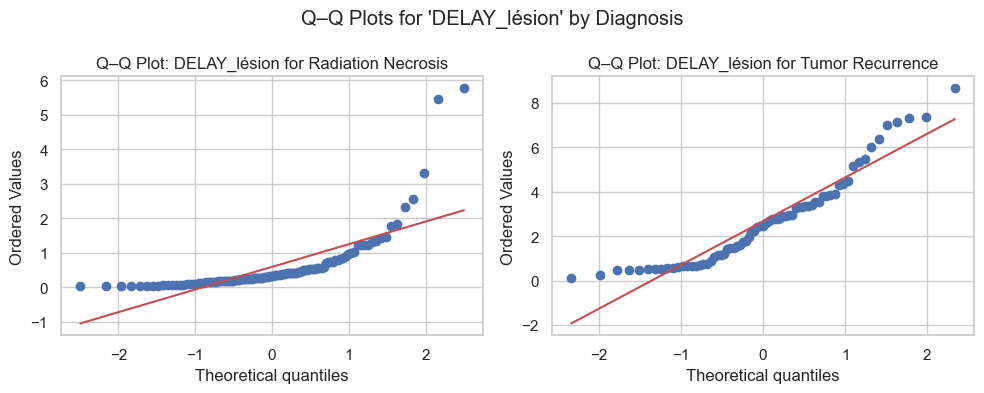

In [13]:
ub.plot_qq_by_group(feature=ub.path)

In [14]:
ub.test_group_difference(feature=ub.path)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -8.1871, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 859.0000, p = 0.0000   → ✅ Significant difference



🔎 [ROC-Based Classification] Feature: 'DELAY_lésion'
--------------------------------------------------------------------------------
AUC (Train) : 0.890  (95% CI: 0.843 – 0.937)
AUC (Test)  : 0.594  (95% CI: 0.338 – 0.850)

 Optimal threshold (Youden’s J): 0.460
 Classification Rule          : Class = 1 if DELAY_lésion ≥ 0.460

▶ TRAIN SET METRICS AT THRESHOLD: 0.460
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      77.3
Recall (Sensitivity) |      97.2
Specificity          |      64.5
Precision            |      63.9
F1 Score             |      77.1

▶ TEST SET METRICS AT THRESHOLD: 0.460
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      47.8
Recall (Sensitivity) |      85.7
Specificity          |      31.2
Precision            |      35.3
F1 Score           

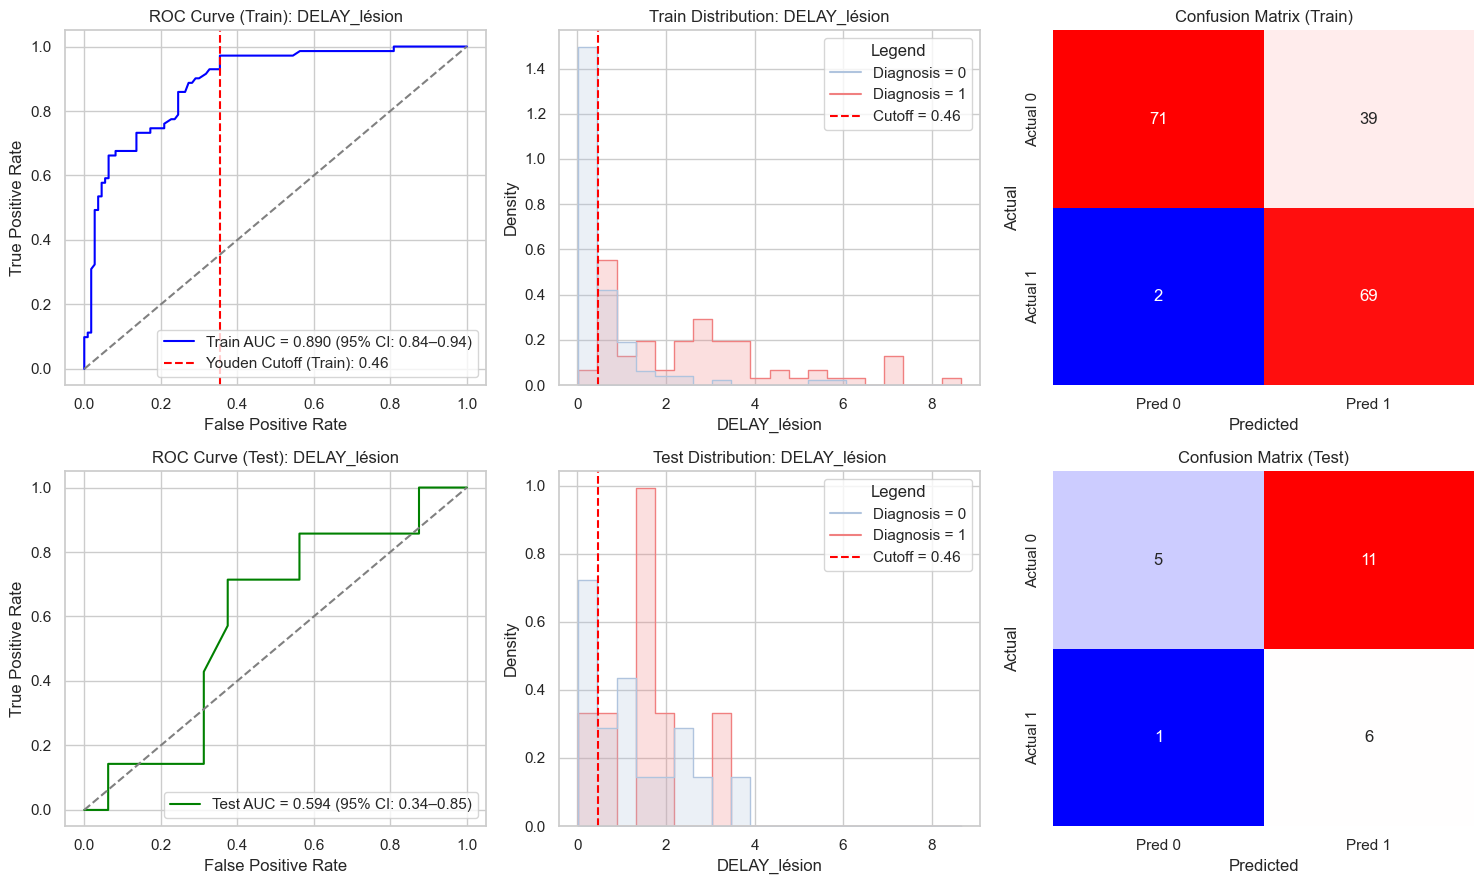

In [15]:
ub.evaluate_feature_predictive_power(feature=ub.path, target_bin_count=20)

### 4.2. Distribution Differences: Path Feature

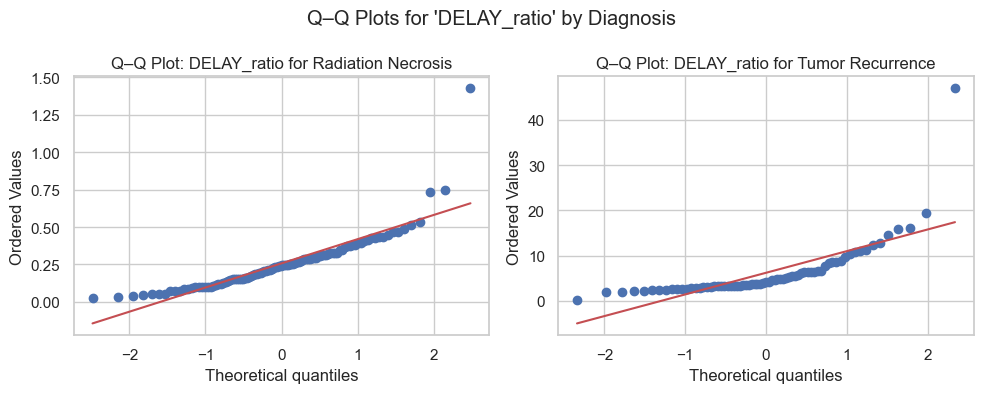

In [16]:
ub.plot_qq_by_group(feature=ub.ratio)

In [17]:
ub.test_group_difference(feature=ub.ratio)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -8.0336, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 43.0000, p = 0.0000   → ✅ Significant difference



🔎 [ROC-Based Classification] Feature: 'DELAY_ratio'
--------------------------------------------------------------------------------
AUC (Train) : 0.994  (95% CI: 0.983 – 1.000)
AUC (Test)  : 0.545  (95% CI: 0.238 – 0.851)

 Optimal threshold (Youden’s J): 1.886
 Classification Rule          : Class = 1 if DELAY_ratio ≥ 1.886

▶ TRAIN SET METRICS AT THRESHOLD: 1.886
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      99.4
Recall (Sensitivity) |      98.6
Specificity          |     100.0
Precision            |     100.0
F1 Score             |      99.3

▶ TEST SET METRICS AT THRESHOLD: 1.886
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      56.5
Recall (Sensitivity) |      28.6
Specificity          |      68.8
Precision            |      28.6
F1 Score             

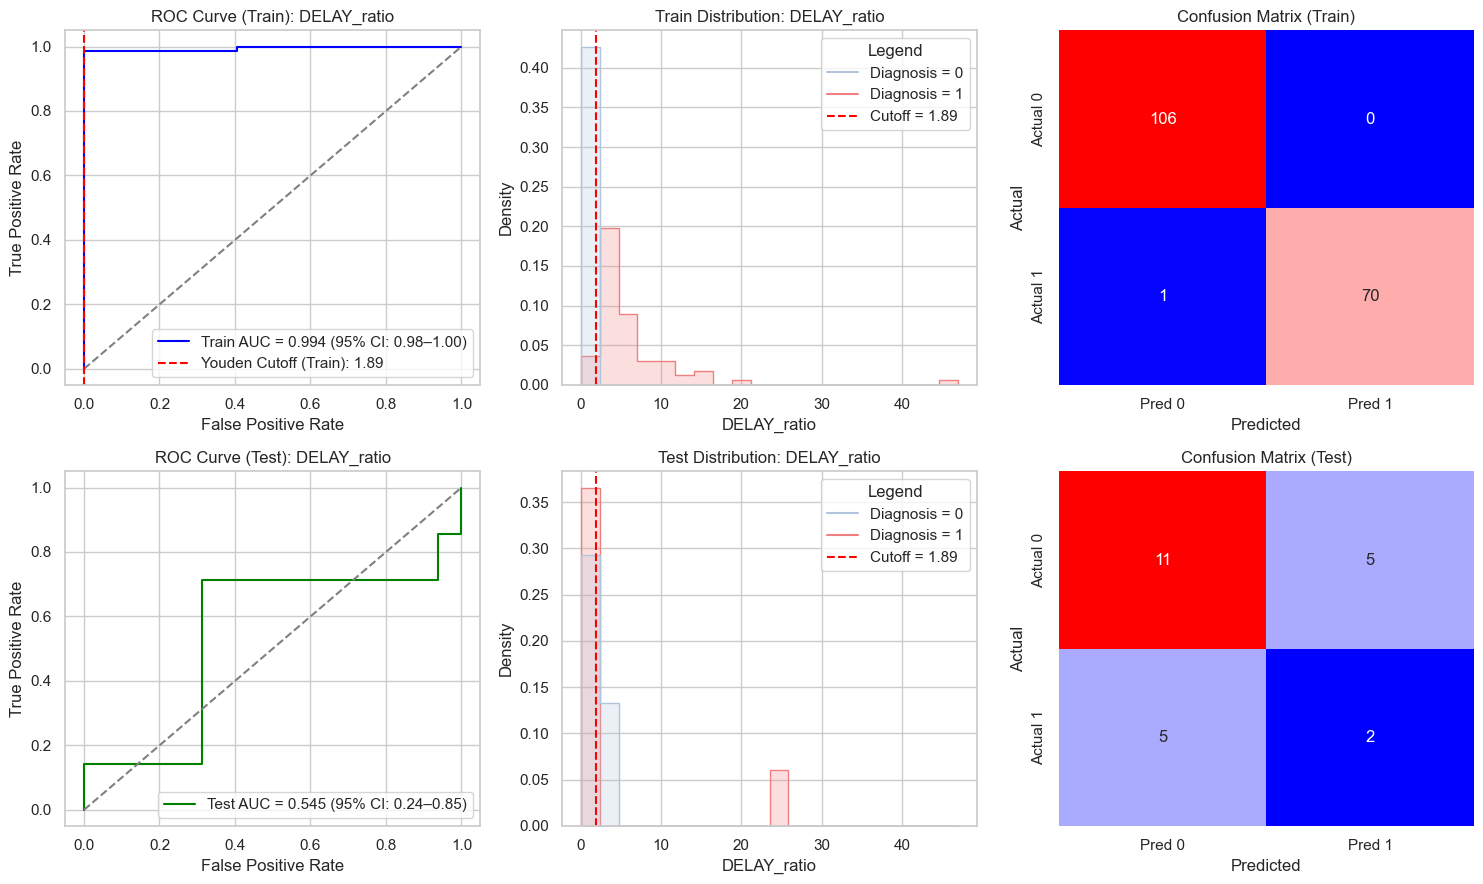

In [18]:
ub.evaluate_feature_predictive_power(feature=ub.ratio, target_bin_count=20)

## 5.  Logistic Regression Modelling

### 5.1 Univariate Logistic Regression 


Logistic Regression Summary for Feature: DELAY_lésion
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 1.2090
Odds Ratio           : 3.3500
Youden's J Threshold : 0.2004
----------------------------------------------------------------------------------------------------

--- Inference Using statsmodels ---
Odds Ratio (statsmodels)  : 3.3500
95% CI for OR             : (2.2664, 4.9517)
p-value                   : 1.3285e-09
----------------------------------------------------------------------------------------------------

▶ [DELAY_LÉSION] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      80.7
Recall (Sensitivity) |      60.6
Specificity          |      93.6
Precision            |      86.0
F1 Score             |      71.1

▶ [DELAY_LÉSION] TRAIN @ YOUDEN
--------------------------------

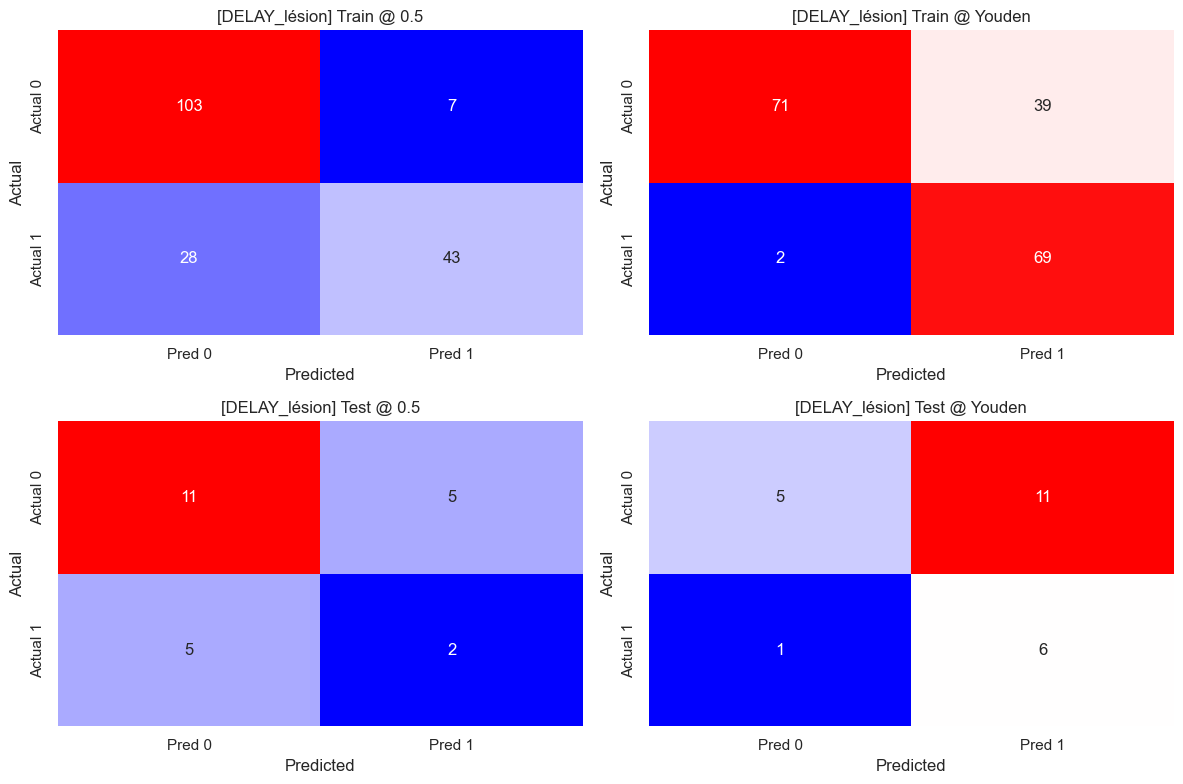

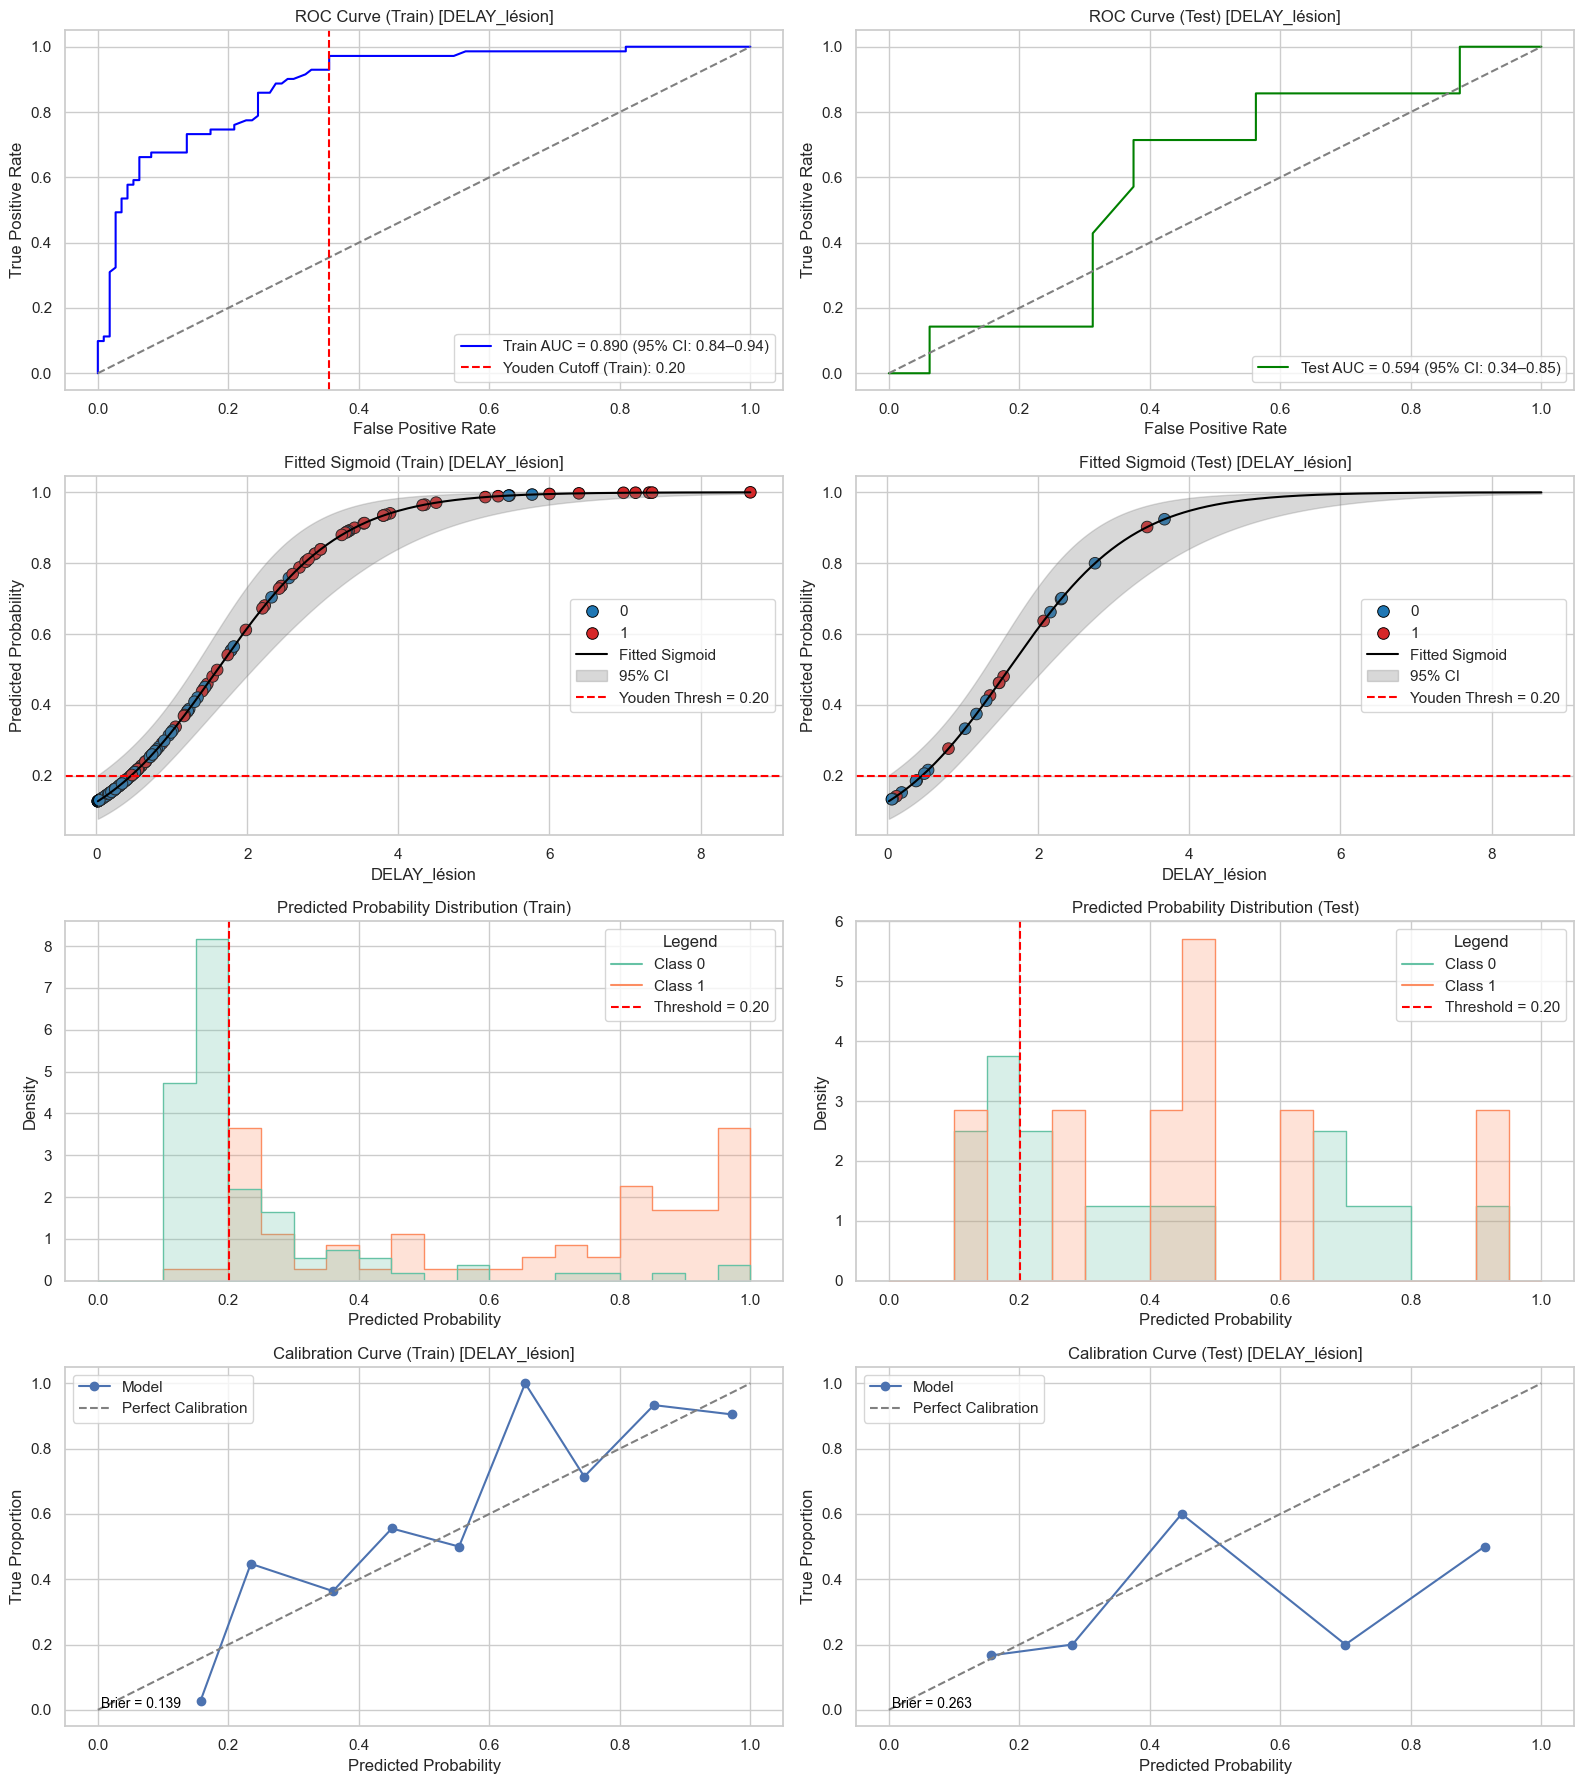

In [19]:
ub.evaluate_logistic_univariate_model(feature=ub.path, target_bin_count=20)


Logistic Regression Summary for Feature: DELAY_ratio
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 4.2818
Odds Ratio           : 72.3718
Youden's J Threshold : 0.8799
----------------------------------------------------------------------------------------------------

--- Inference Using statsmodels ---
Odds Ratio (statsmodels)  : 72.3717
95% CI for OR             : (8.8709, 590.4337)
p-value                   : 6.3849e-05
----------------------------------------------------------------------------------------------------

▶ [DELAY_RATIO] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      98.9
Recall (Sensitivity) |      98.6
Specificity          |      99.1
Precision            |      98.6
F1 Score             |      98.6

▶ [DELAY_RATIO] TRAIN @ YOUDEN
-------------------------------

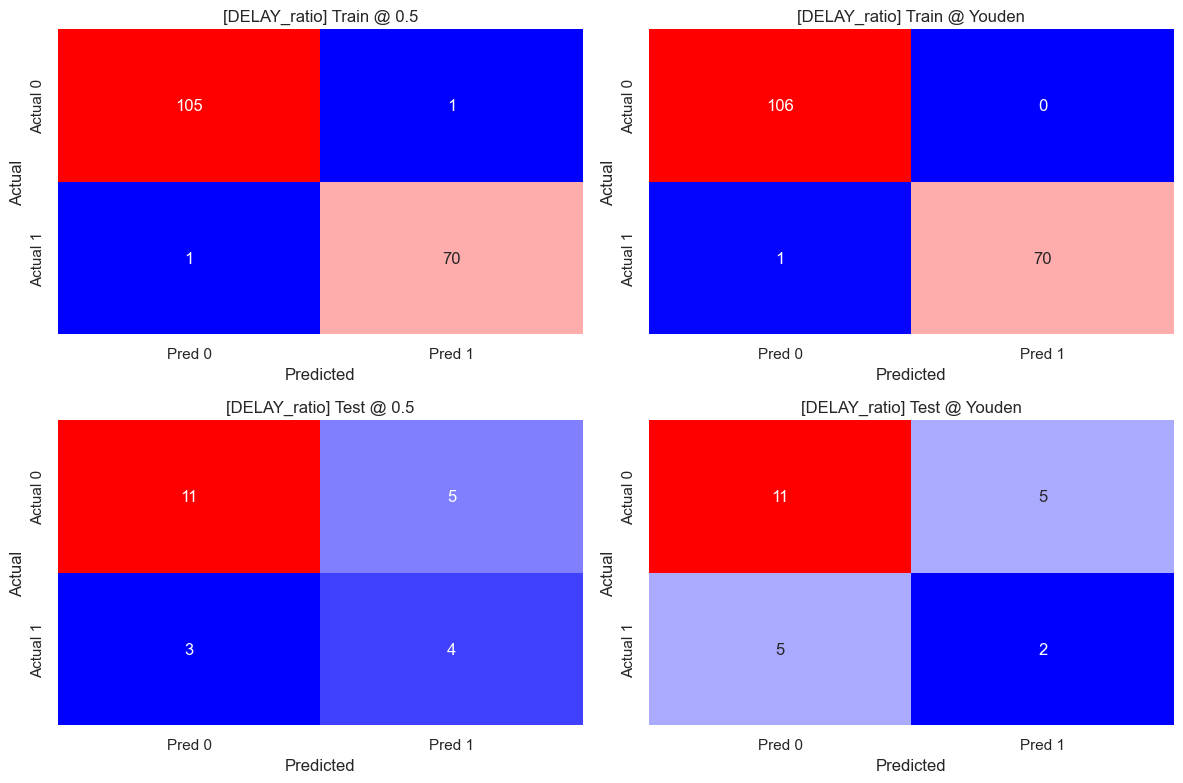

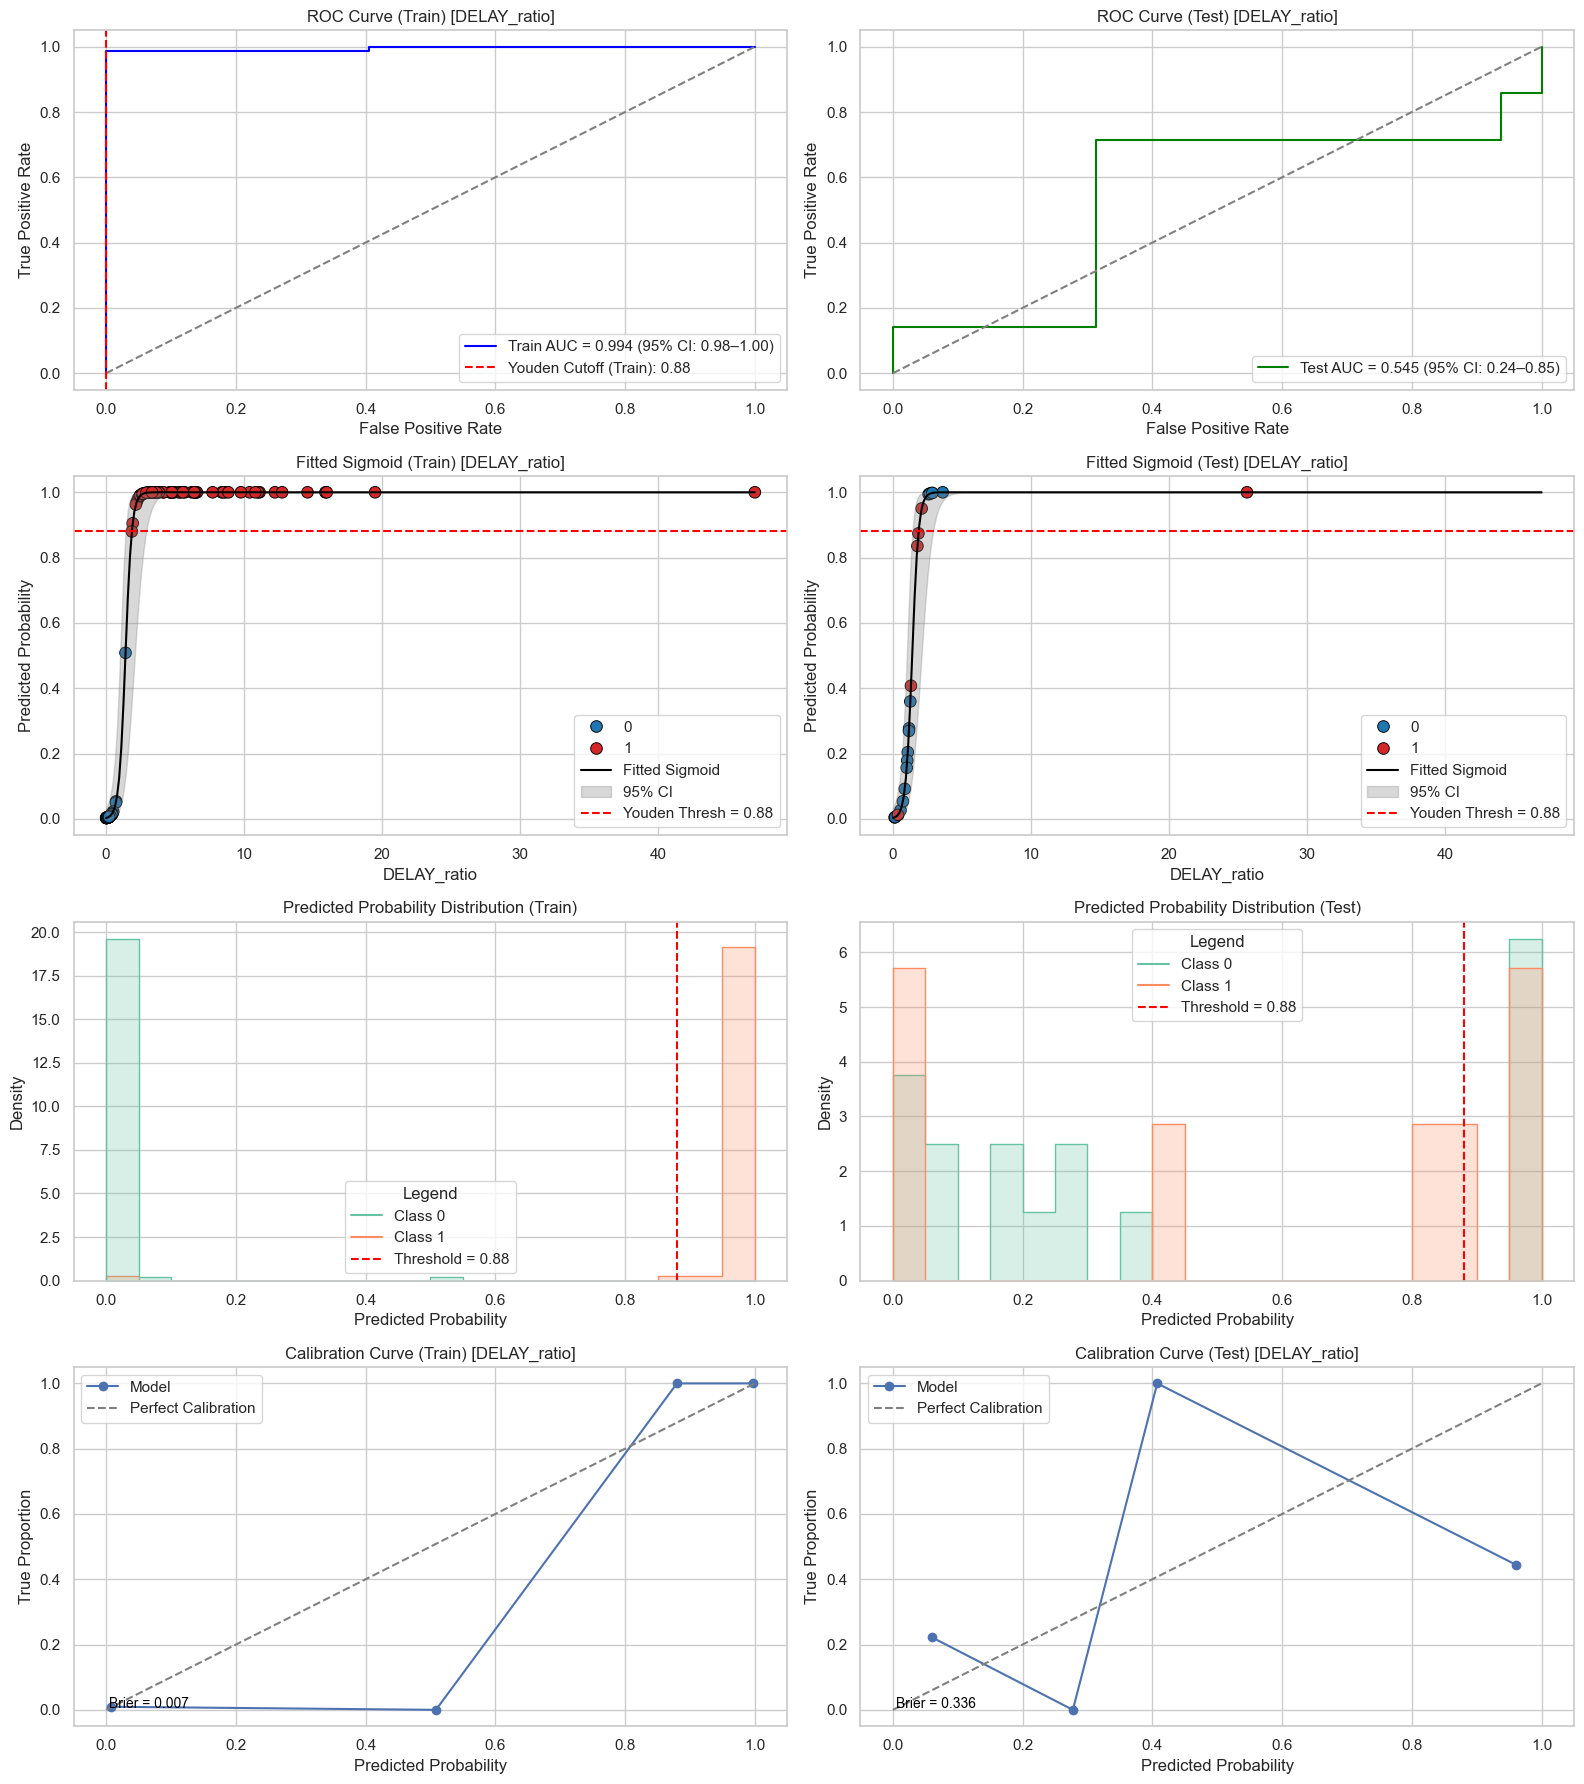

In [20]:
ub.evaluate_logistic_univariate_model(feature=ub.ratio,  target_bin_count=20)

### 5.2 Bivariate Logistic Regression 

BIVARIATE LOGISTIC REGRESSION: DELAY_lésion + DELAY_control
----------------------------------------------------------------------------------------------------
AUC (Train): 0.998 (95% CI: 0.993 – 1.000)
AUC (Test) : 0.580 (95% CI: 0.258 – 0.903)
Optimal Threshold (Youden’s J): 0.812

▶ [DELAY_LÉSION + DELAY_CONTROL] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      98.9
Recall (Sensitivity) |      98.6
Specificity          |      99.1
Precision            |      98.6
F1 Score             |      98.6

▶ [DELAY_LÉSION + DELAY_CONTROL] TRAIN @ YOUDEN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      99.4
Recall (Sensitivity) |      98.6
Specificity          |     100.0
Precision            |     100.0
F1 Score             |      99.3

▶ [DELAY_LÉSION +

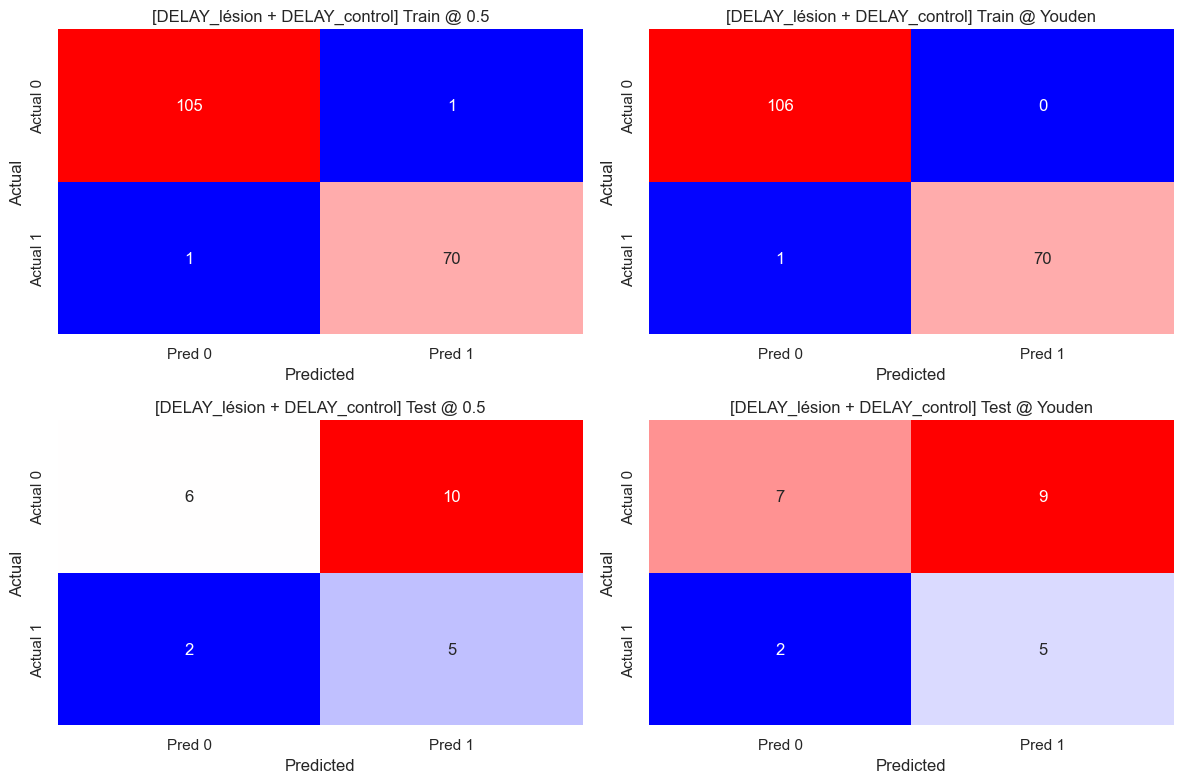

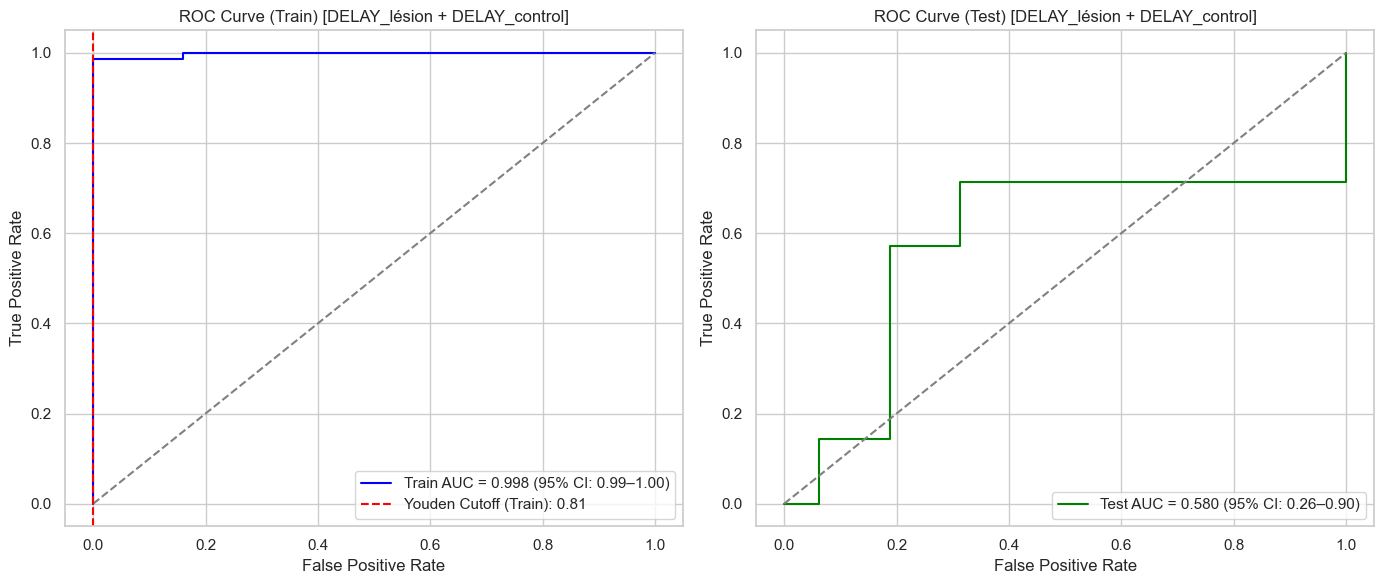

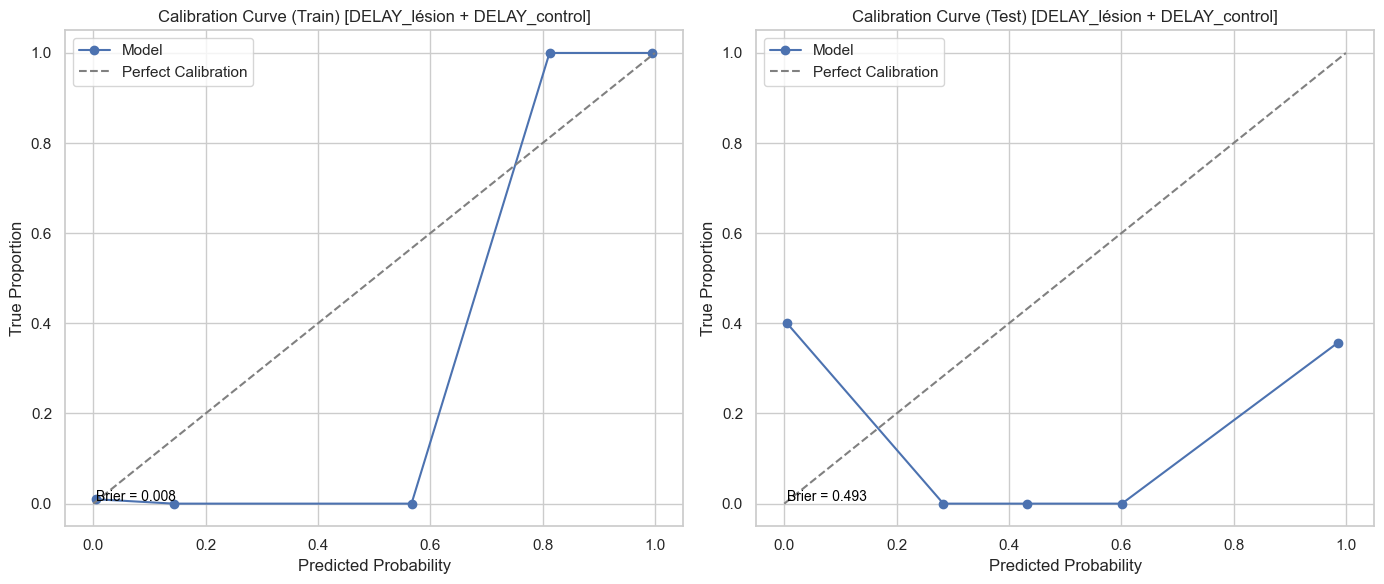

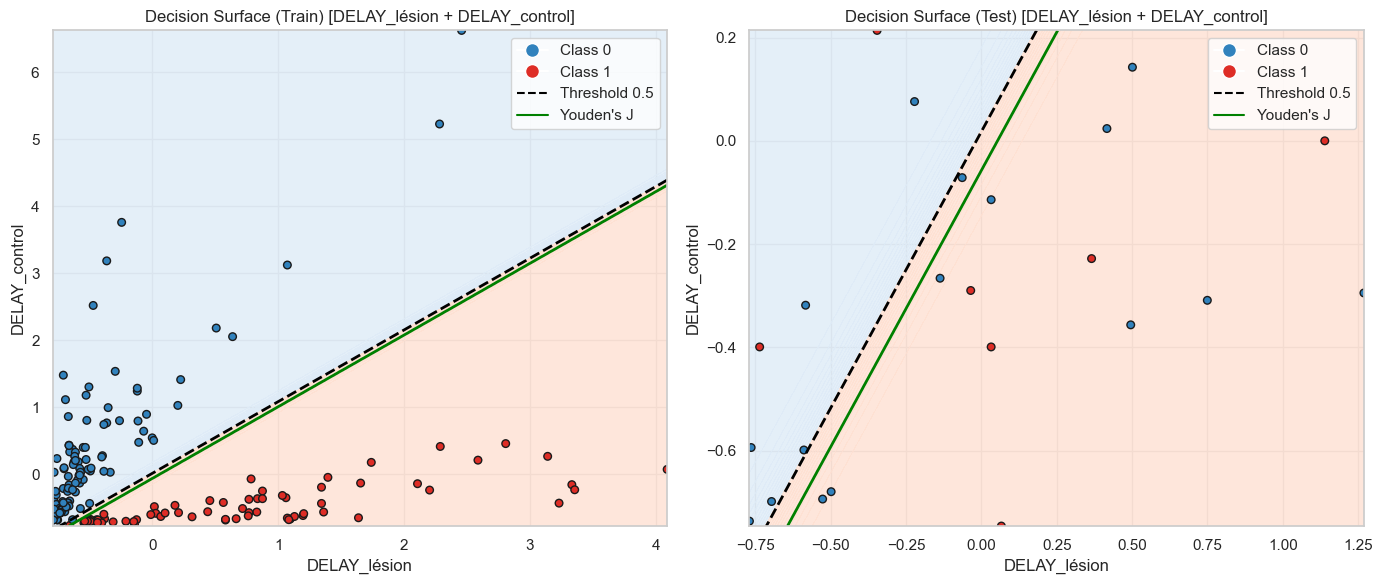

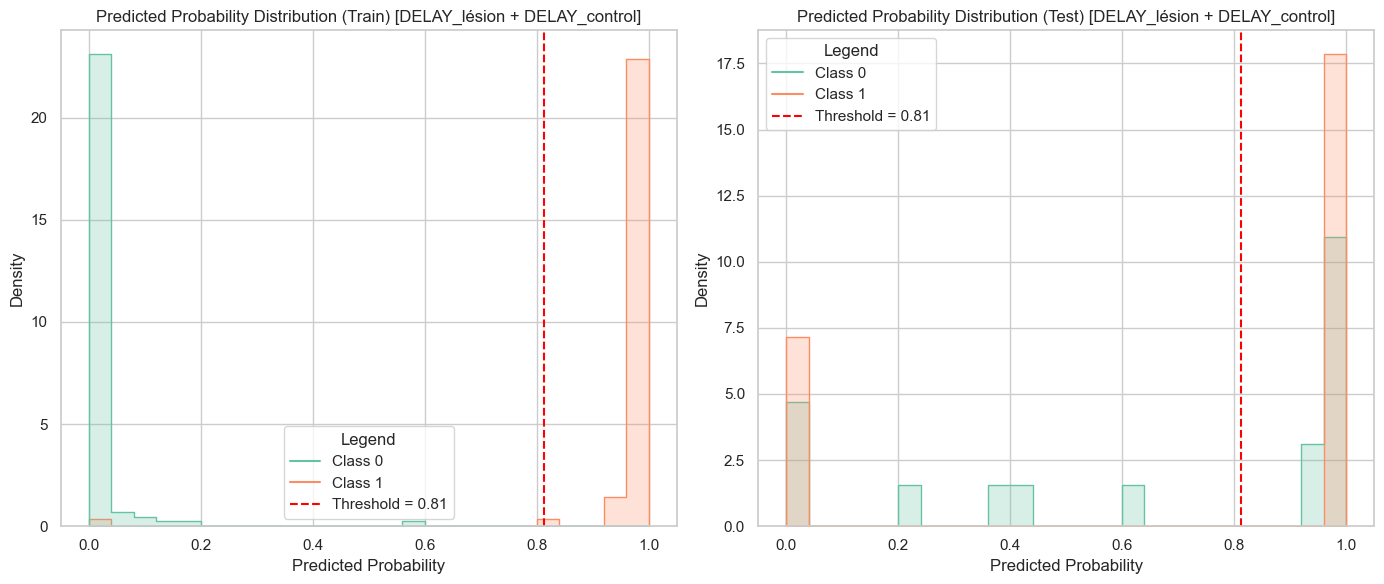

In [21]:
ub.evaluate_logistic_bivariate_model(target_bin_count=25)

## 5.  SVM Modelling

SVM (LINEAR) BIVARIATE: DELAY_lésion + DELAY_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 0.997 (95% CI: 0.992 – 1.000)
[Margin] Test  AUC : 0.562 (95% CI: 0.246 – 0.879)
Optimal Margin Cutoff (Youden): -0.164
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 0.997 (95% CI: 0.992 – 1.000)
[Proba]  Test  AUC : 0.562 (95% CI: 0.246 – 0.879)
Optimal Proba  Cutoff (Youden): 0.548

▶ [DELAY_LÉSION + DELAY_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      98.9
Recall (Sensitivity) |      97.2
Specificity          |     100.0
Precision            |     100.0
F1 Score             |      98.6

▶ [DELAY_LÉSION + DELAY_CONTROL] TRAIN @ F(X) ≥ YOUDEN
--------------------------------------------------
Metri

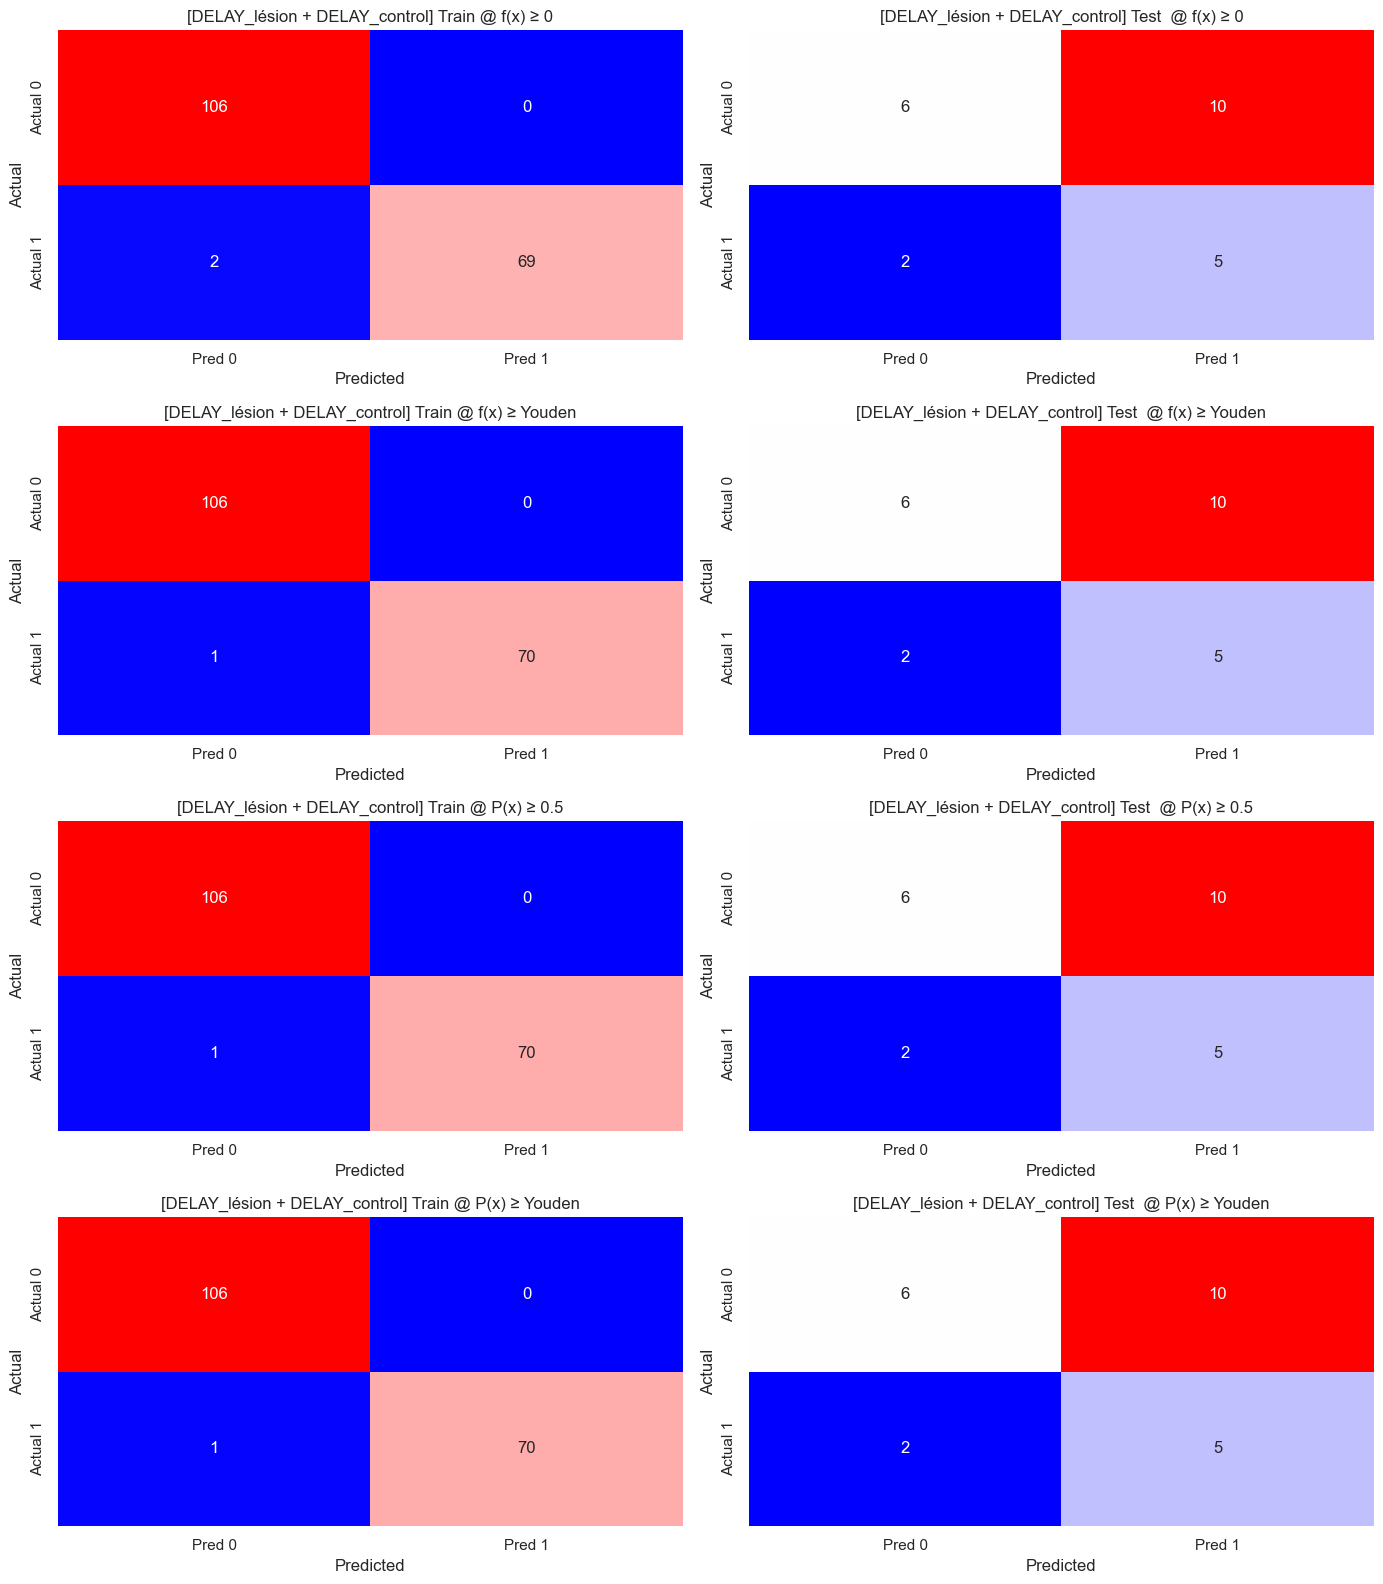

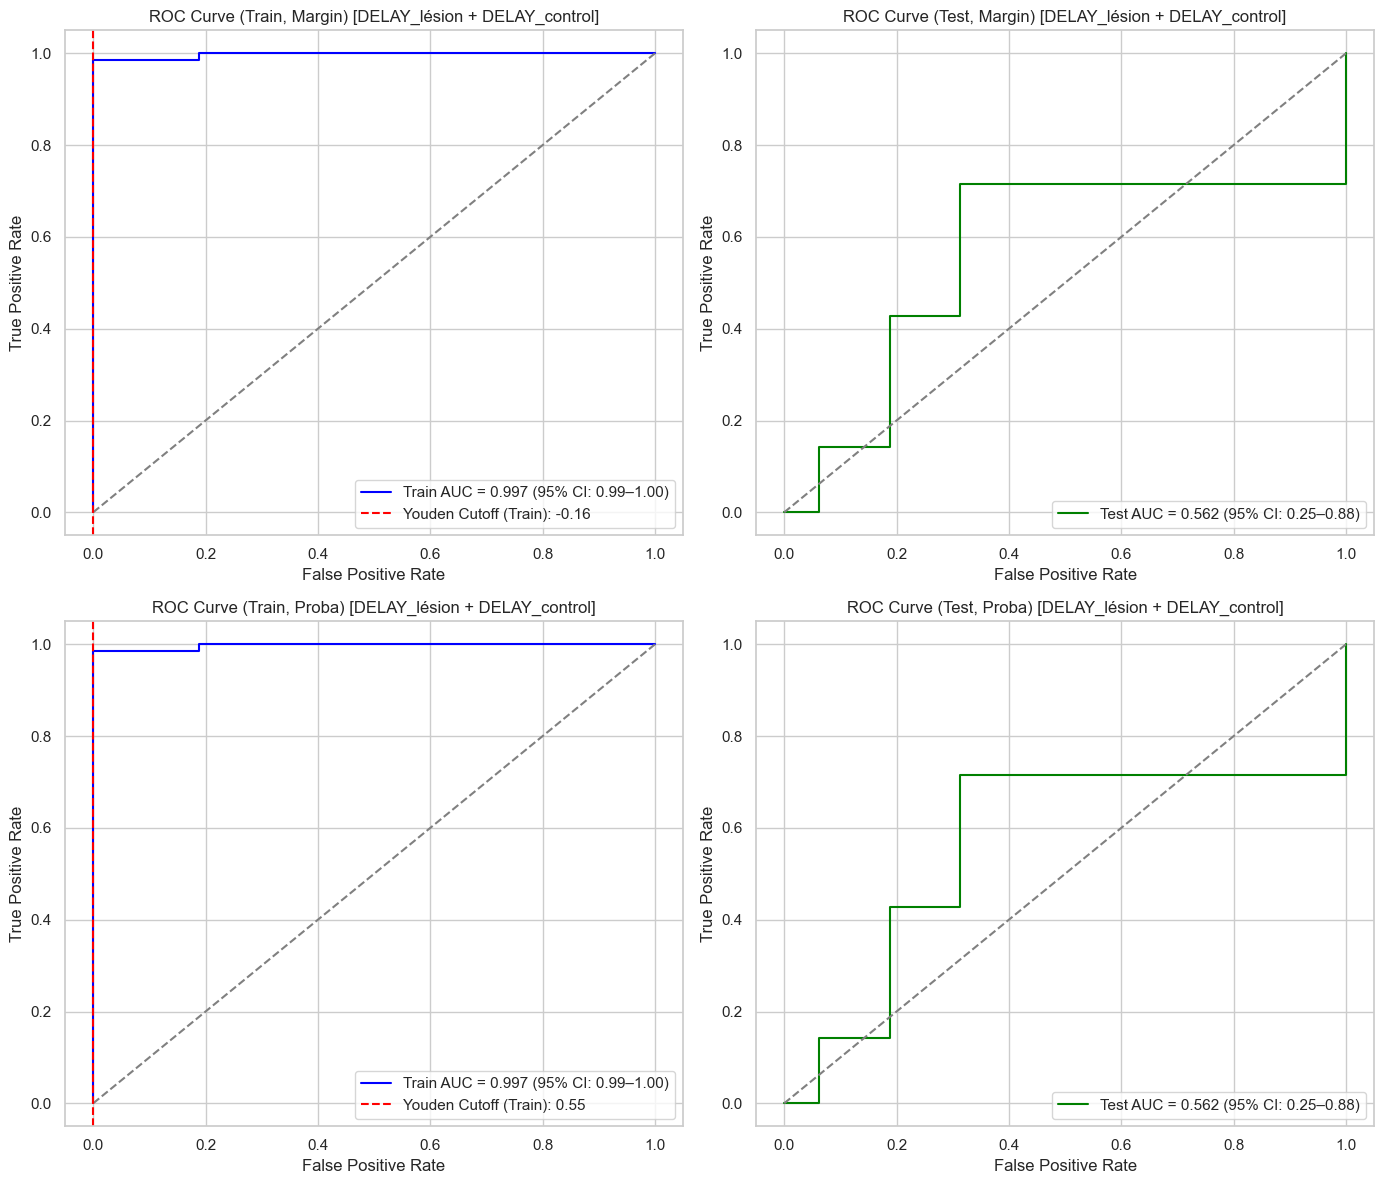

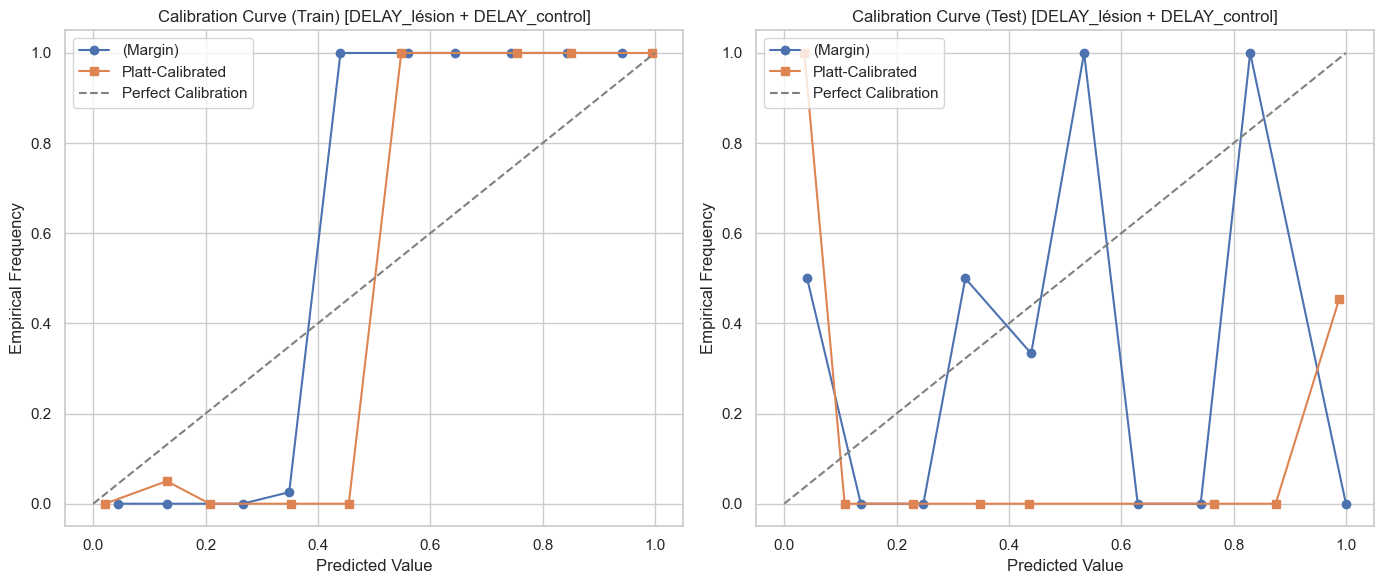

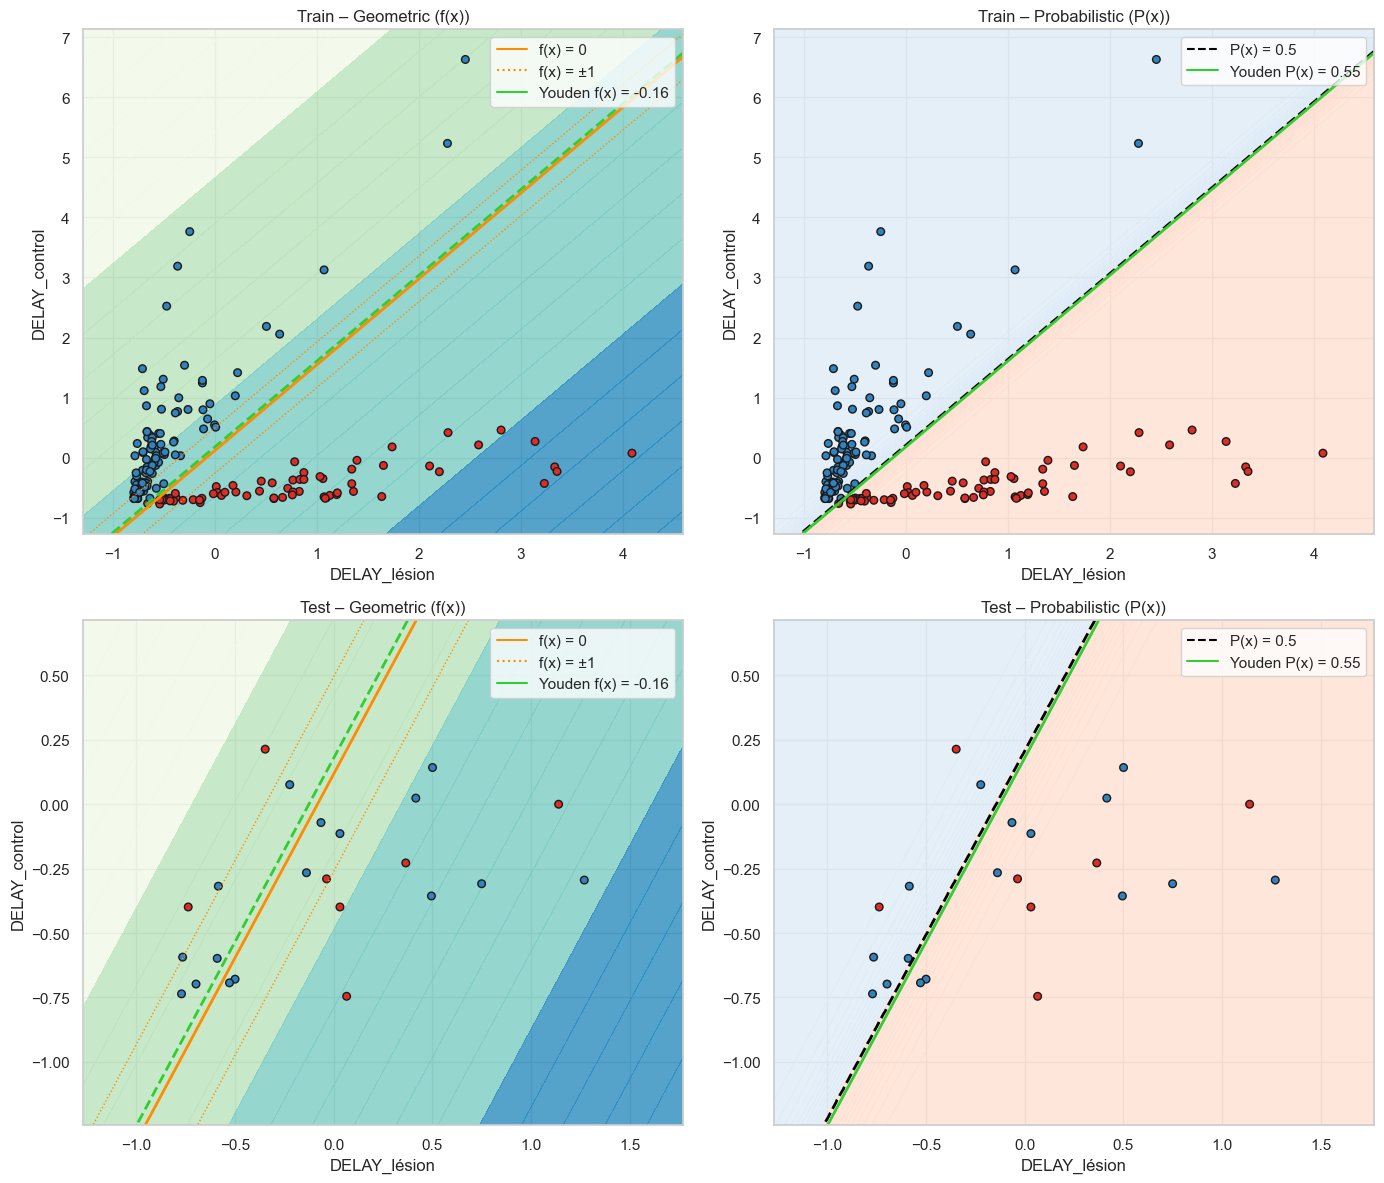

In [22]:
ub.evaluate_svm_bivariate_model(kernel="linear")

SVM (RBF) BIVARIATE: DELAY_lésion + DELAY_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 0.996 (95% CI: 0.989 – 1.000)
[Margin] Test  AUC : 0.598 (95% CI: 0.270 – 0.926)
Optimal Margin Cutoff (Youden): -0.209
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 0.996 (95% CI: 0.989 – 1.000)
[Proba]  Test  AUC : 0.598 (95% CI: 0.270 – 0.926)
Optimal Proba  Cutoff (Youden): 0.558

▶ [DELAY_LÉSION + DELAY_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      98.9
Recall (Sensitivity) |      97.2
Specificity          |     100.0
Precision            |     100.0
F1 Score             |      98.6

▶ [DELAY_LÉSION + DELAY_CONTROL] TRAIN @ F(X) ≥ YOUDEN
--------------------------------------------------
Metric  

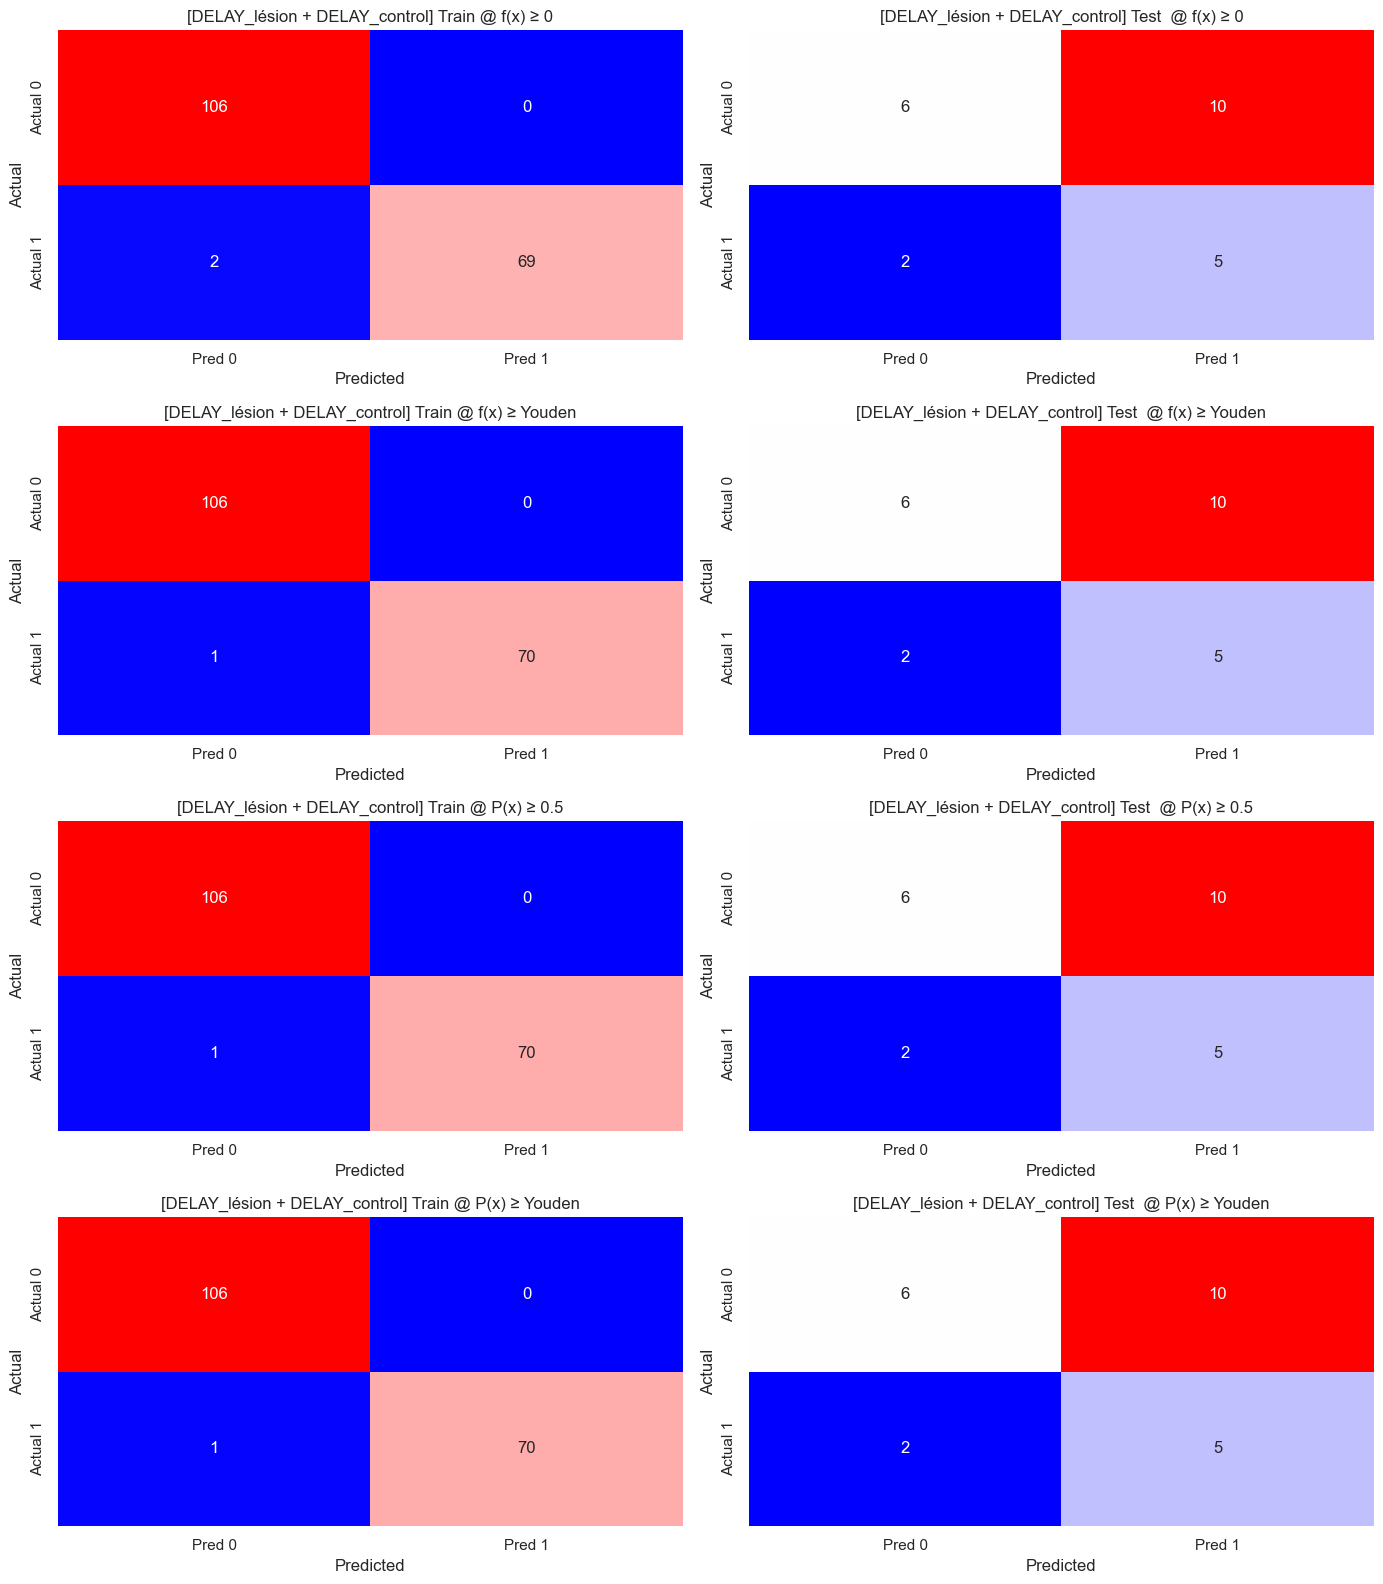

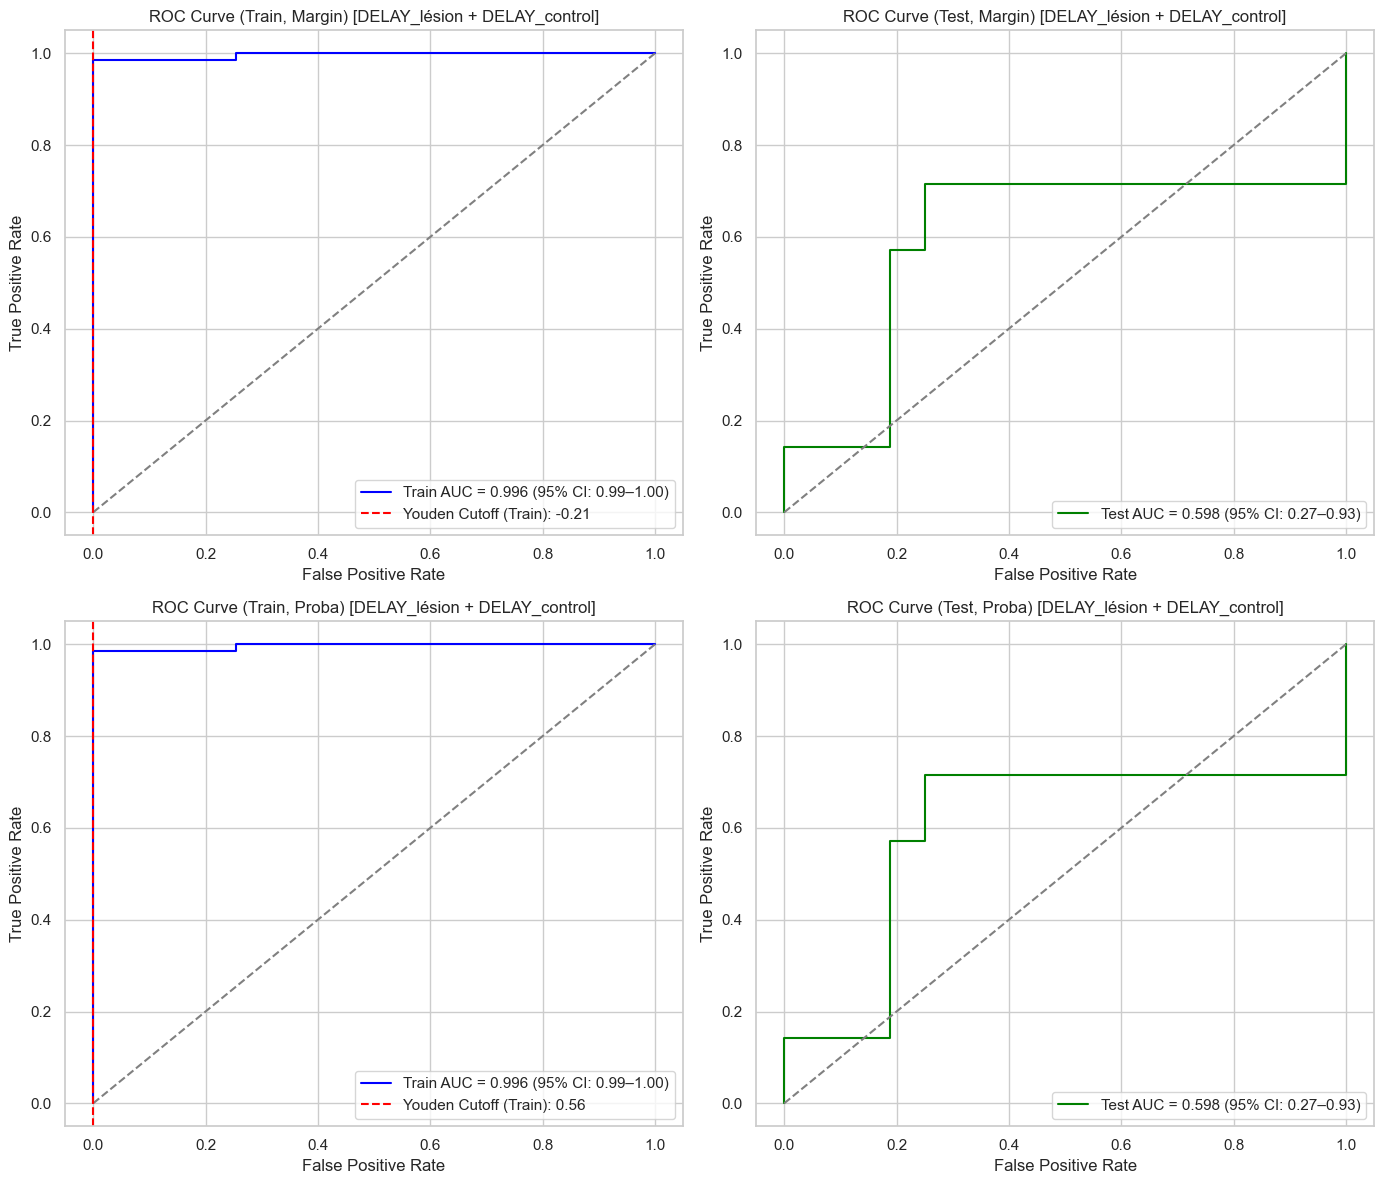

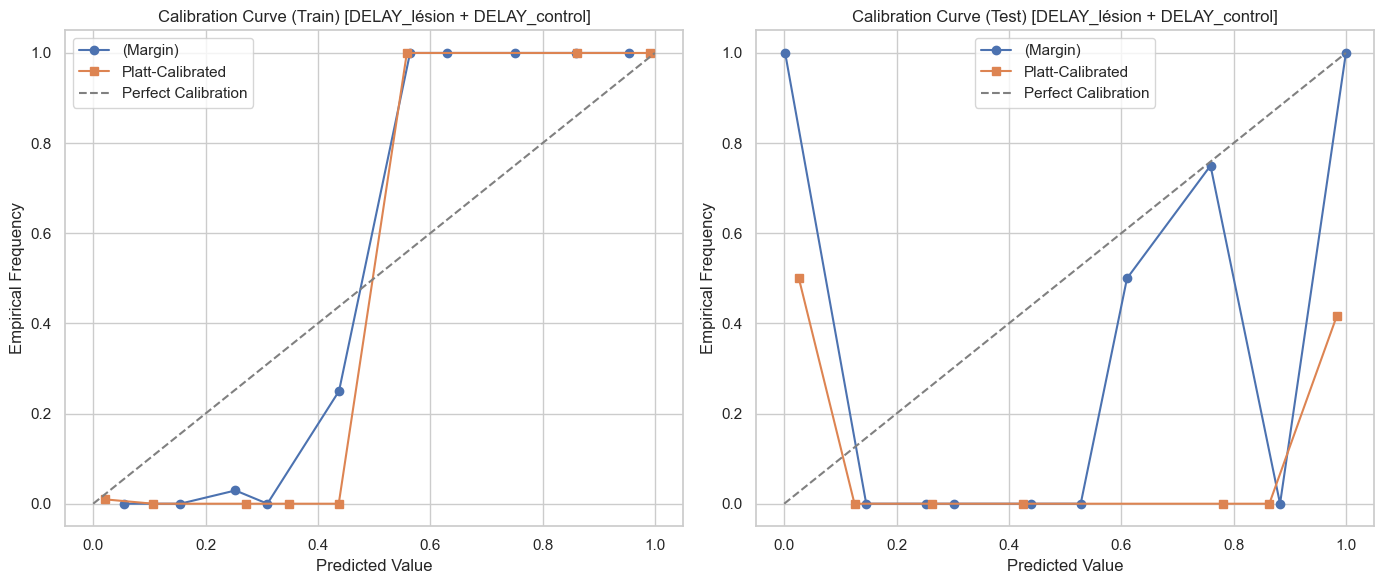

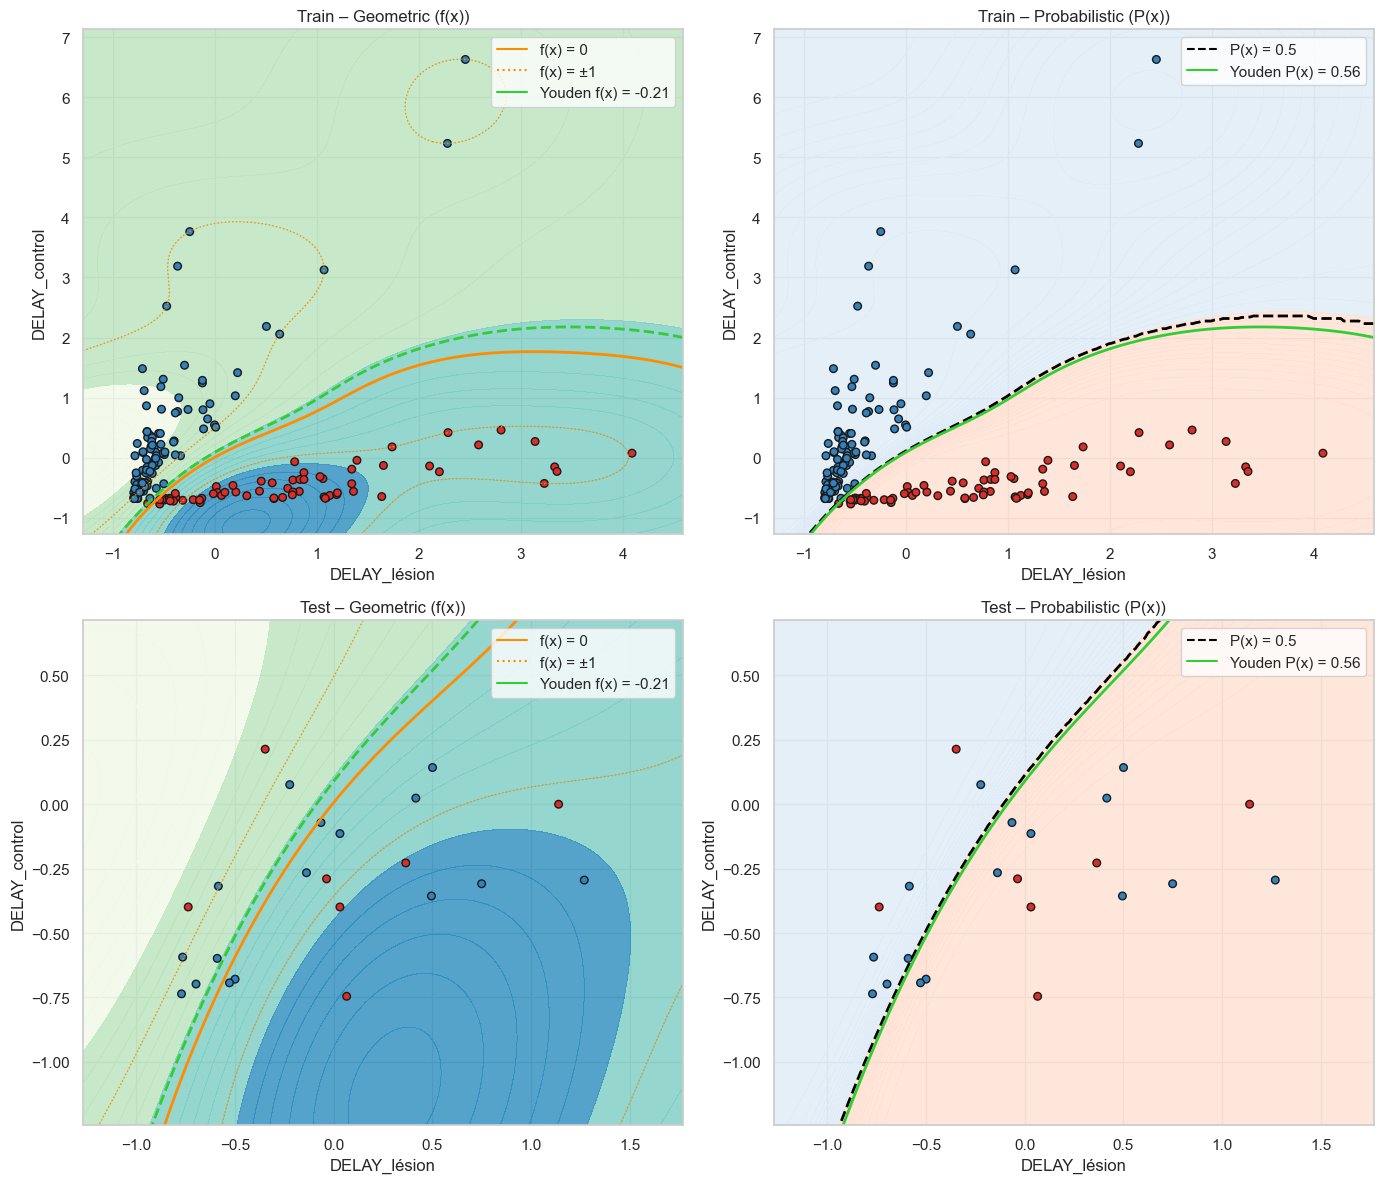

In [23]:
ub.evaluate_svm_bivariate_model(kernel="rbf")

## 6.  Decision Tree Modelling

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
DECISION TREE (max_depth=3, criterion=GINI): DELAY_lésion + DELAY_control + DELAY_ratio
----------------------------------------------------------------------------------------------------
AUC (Train): 1.000 (95% CI: 1.000 – 1.000)
AUC (Test) : 0.629 (95% CI: 0.399 – 0.860)
----------------------------------------------------------------------------------------------------

▶ [DELAY_LÉSION + DELAY_CONTROL + DELAY_RATIO] TRAIN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score             |     100.0

▶ [DELAY_LÉSION + DELAY_CONTROL + DELAY_RATIO] TEST
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accura

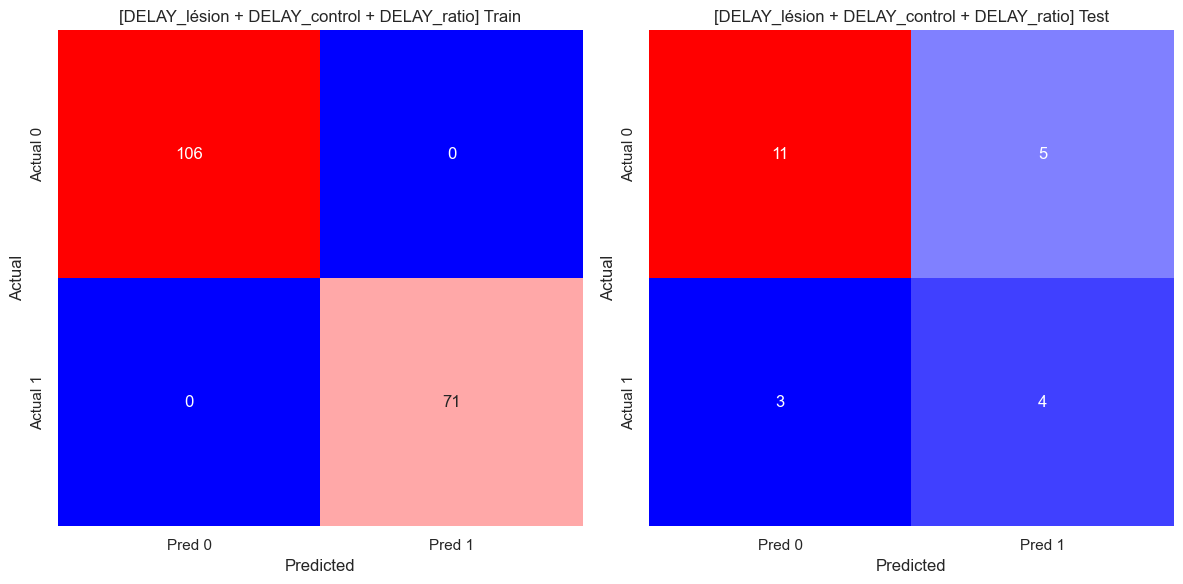

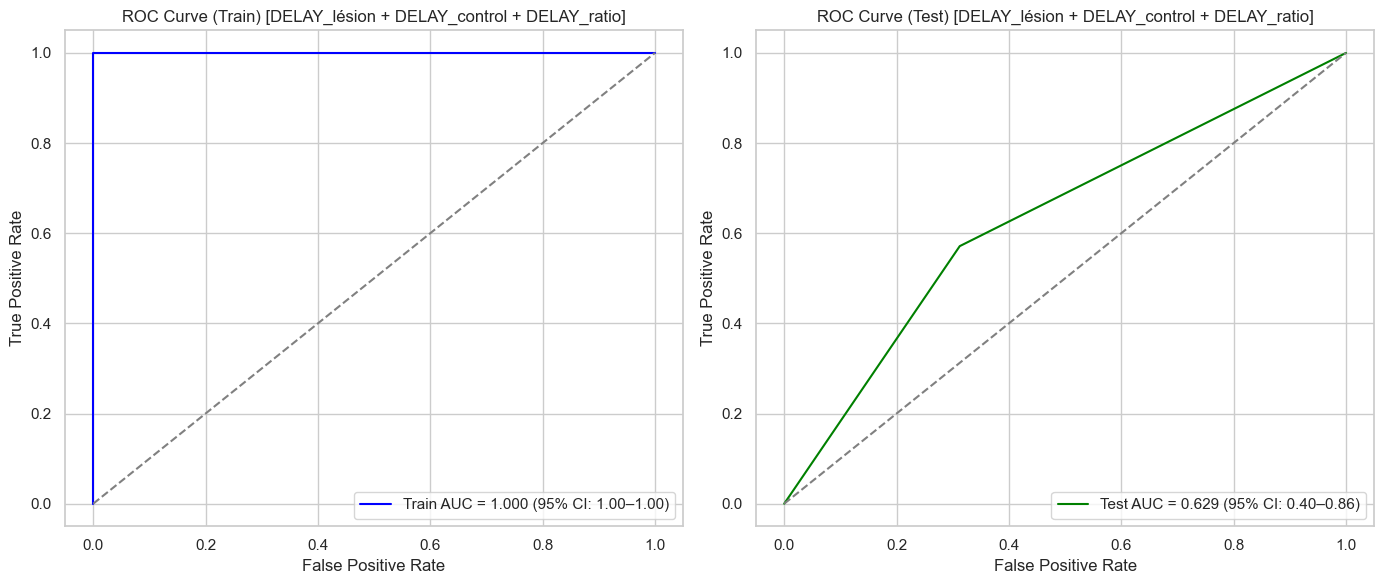

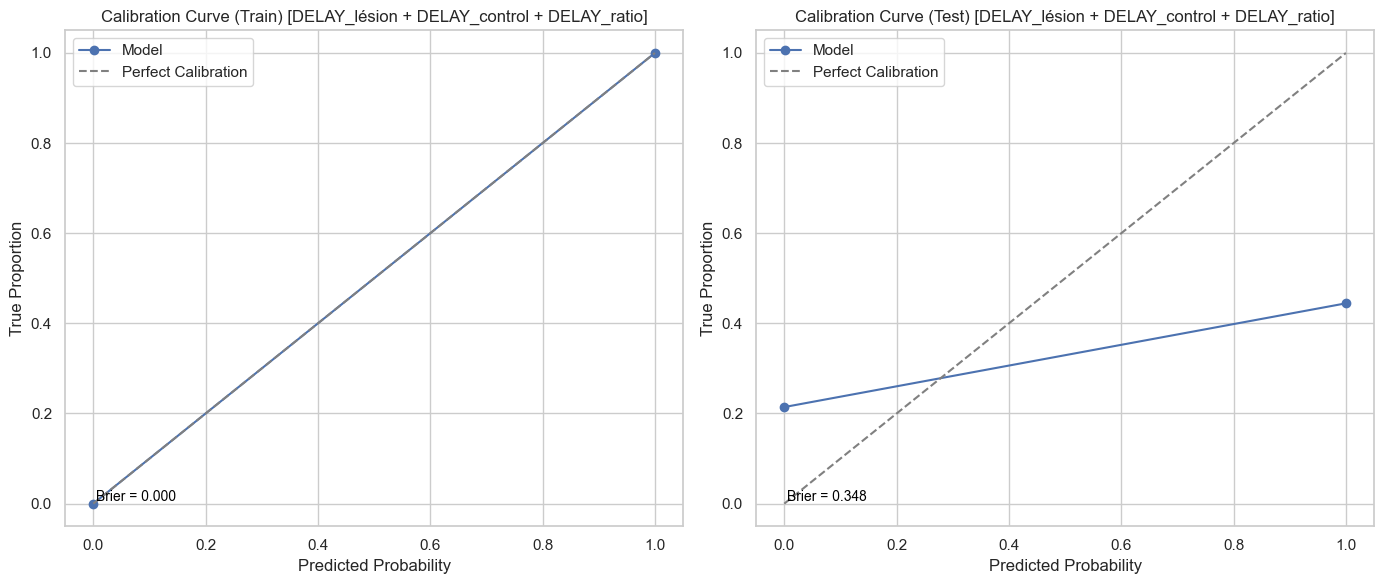

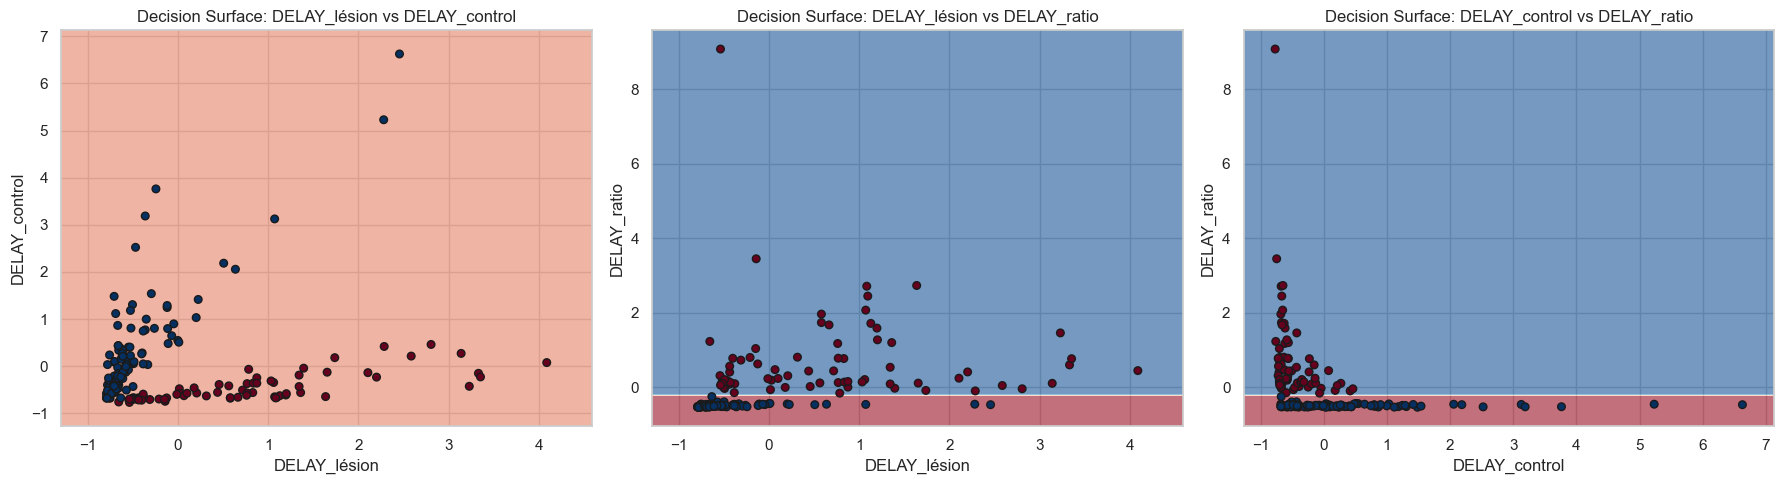

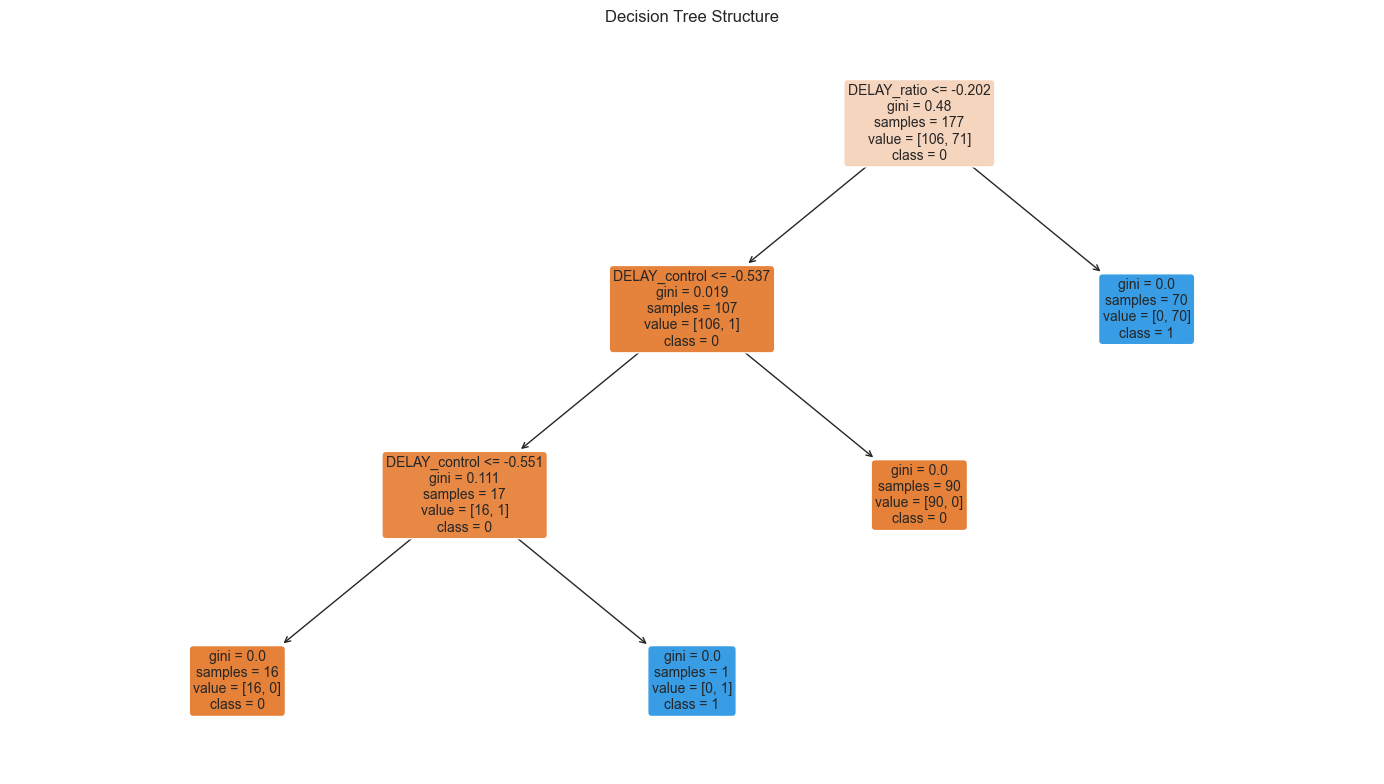


Tree Rules :
--------------------------------------------------------------------------------
|--- DELAY_ratio <= -0.20
|   |--- DELAY_control <= -0.54
|   |   |--- DELAY_control <= -0.55
|   |   |   |--- class: 0
|   |   |--- DELAY_control >  -0.55
|   |   |   |--- class: 1
|   |--- DELAY_control >  -0.54
|   |   |--- class: 0
|--- DELAY_ratio >  -0.20
|   |--- class: 1



In [24]:
ub.evaluate_tree_trivariate_model()